## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import r2_score
import pickle

In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')
sys.path.insert(1, './params')
#from cper_bm_params_eval_plot_transect import *
#from cper_bm_params_eval_spatial_transect import *
#from cper_bm_params_eval_ecosite_transect import *
#from cper_bm_params_eval_year_transect import *
from cper_bm_params_eval_kmeans_transect import *

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch
from dnn_setup import ResNetRegressor, ResidualBlock

## Define I/O

In [4]:
from importlib import reload
#reload(sys.modules["cper_bm_params_eval_year_transect"])
#from cper_bm_params_eval_year_plot import *

In [5]:
save_results = True
outDIR = './results'

## Load and pre-process data

In [6]:
with open(os.path.join(inDIR, 'ml_train_' + nickname + '_cv_' + kfold_group + '_tuneby_' + tuneby_group + '_results.pk'), 'rb') as f:
    mod_dict = pickle.load(f)
df = pd.read_csv(inPATH)
if 'transect' in inPATH:
    df['Plot'] = df[id_col].transform(lambda x: '_'.join(x.split('_')[:-1]))
elif 'plot' in inPATH:
    df['Plot'] = df[id_col]

In [7]:
if 'Plot' not in id_cols:
    id_cols = id_cols + ['Plot']
print(id_cols)

['Id', 'Plot', 'Pasture', 'Date_mean', 'Year', 'Season', 'Observed']


In [8]:
keep_cols = var_names + id_cols + [logo_group, y_col, date_col, past_col, id_col] + group_cols + list(mod_dict.keys())

In [9]:
drop_cols = [x for x in df.columns if x not in keep_cols]

In [10]:
drop_cols

['Date', 'Low', 'High', 'geometry', 'Kmeans']

In [11]:
def r_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    r = corr
    return r

In [12]:
df_bm_pred = pd.melt(df.drop(columns=drop_cols + var_names).rename(columns={y_col: 'Observed'}), 
                 id_vars=id_cols + [logo_group], 
                 value_name='Predicted',
                 var_name='Source')

In [13]:
[x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]

['Id', 'Plot', 'Pasture', 'Date_mean', 'Year', 'Season', 'Observed', 'kfold']

In [14]:
df_ens_lin = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_lin['Source'] = 'ENS_LIN'

df_ens_ml = df_bm_pred[df_bm_pred['Source'].isin(
    ['SVR', 'RF', 'GBR', 'HGBR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_ml['Source'] = 'ENS_ML'

df_ens_both = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR', 'HGBR'])].drop(columns=['Source']).groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_both['Source'] = 'ENS_ALL'

In [15]:
df_bm_pred = pd.concat([df_bm_pred, df_ens_lin, df_ens_ml, df_ens_both])

In [16]:
for k in df_bm_pred['Source'].unique():
    if k in mod_dict.keys():
        if mod_dict[k]['xfrm_y'] is not None:
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Observed_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Predicted_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])
    else:
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Observed_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Predicted_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])

In [17]:
mods = ['CPER_2022', 'OLS_2022', 'OLS', 
        'LASSO', 'PLS', 'PCR', 
        'SVR', 'RF', 'GBR', 'HGBR', 'DNN',
        'ENS_LIN', 'ENS_ML', 'ENS_ALL']

In [18]:
df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                      categories=mods)

In [19]:
df_bm_pred['Source'] = df_bm_pred['Source'].cat.remove_unused_categories()

In [20]:
df_bm_pred[df_bm_pred['Source'].isnull()]

Empty DataFrame
Columns: [Id, Plot, Pasture, Date_mean, Year, Season, Observed, kfold, Source, Predicted, Observed_xfrm, Predicted_xfrm]
Index: []

In [21]:
df_bm_pred[df_bm_pred['Predicted_xfrm'].isnull()]#['Year'].unique()

Empty DataFrame
Columns: [Id, Plot, Pasture, Date_mean, Year, Season, Observed, kfold, Source, Predicted, Observed_xfrm, Predicted_xfrm]
Index: []

In [22]:
df_bm_pred

Id    Plot Pasture   Date_mean  Year   Season     Observed  kfold  \
0     10S_P1_1  10S_P1     10S  2014-06-12  2014     June  1280.282775      0   
1     31E_P4_1  31E_P4     31E  2014-06-12  2014     June  1557.012039      4   
2     31E_P3_4  31E_P3     31E  2014-06-12  2014     June   746.019804      2   
3     31E_P3_3  31E_P3     31E  2014-06-12  2014     June   717.349423      4   
4     31E_P3_2  31E_P3     31E  2014-06-12  2014     June  1288.316568      4   
...        ...     ...     ...         ...   ...      ...          ...    ...   
9642   CN_P4_4   CN_P4      CN  2021-10-18  2021  October   332.196029      6   
9643   CN_P4_4   CN_P4      CN  2022-06-13  2022     June   289.400595      1   
9644   CN_P4_4   CN_P4      CN  2022-10-05  2022  October     7.698318      1   
9645   CN_P4_4   CN_P4      CN  2023-06-22  2023     June   930.182632      4   
9646   CN_P4_4   CN_P4      CN  2023-10-19  2023  October   502.036020      8   

         Source    Predicted  Observed_xfrm  Predicted_xfrm  
0     CPER_2022  1614.799447       7.155617        7.387585  
1     CPER_2022   953.400493       7.351166        6.861083  
2     CPER_2022   812.821793       6.616092        6.701741  
3     CPER_2022   688.037089       6.576956        6.535295  
4     CPER_2022   693.749549       7.161868        6.543551  
...         ...          ...            ...             ...  
9642    ENS_ALL   709.408549      18.226246       26.634724  
9643    ENS_ALL   436.856765      17.011778       20.901119  
9644    ENS_ALL   385.342093       2.774584       19.630132  
9645    ENS_ALL   952.014893      30.498896       30.854739  
9646    ENS_ALL   754.157986      22.406160       27.461937  

[115764 rows x 12 columns]

## Check disaggregated prediction

In [23]:
#df_bm_pred = df_bm_pred.groupby([mod_col, logo_group,  id_col, date_col] + group_cols).mean().reset_index().dropna()

In [24]:
mae_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted_xfrm'] - x['Observed_xfrm'])), include_groups=False).round(4)
bias_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(x['Predicted_xfrm'] - x['Observed_xfrm']), include_groups=False).round(4)
mae_bt_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted'] - x['Observed'])), include_groups=False).round(4)
r2_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    (lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm'])), include_groups=False).round(4)
r2_corr_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']), include_groups=False).round(4)

In [25]:
df_smry_obs = pd.DataFrame({
    'MAE': mae_obs.round(4),
    'Bias': bias_obs.round(4),
    'R^2': r2_obs.round(4),
    'r': r2_corr_obs.round(4),
    'MAE_bt': mae_bt_obs.round(4),
    'MAE_bt_pct': (mae_bt_obs / df_bm_pred[[mod_col, 'Observed']].groupby([mod_col], observed=True).mean()['Observed']).round(4),
})
display(df_smry_obs)

MAE    Bias     R^2       r    MAE_bt  MAE_bt_pct
Source                                                         
CPER_2022  0.3563  0.0274  0.4957  0.7055  286.5450      0.3350
OLS_2022   4.2656 -0.1507  0.5886  0.7674  254.1223      0.2971
OLS        4.1325 -0.1891  0.6063  0.7790  246.9722      0.2888
LASSO      3.9761 -0.0240  0.6417  0.8011  238.5825      0.2790
PLS        4.0486 -0.1252  0.6245  0.7904  243.2333      0.2844
PCR        4.0426 -0.0473  0.6268  0.7918  242.6917      0.2838
SVR        4.0419 -0.6004  0.6208  0.7911  242.4803      0.2835
RF         4.0248 -0.0403  0.6244  0.7915  243.2505      0.2844
HGBR       3.9967 -0.2031  0.6311  0.7951  241.1987      0.2820
ENS_LIN    4.0071 -0.0609  0.6343  0.7964  240.6730      0.2814
ENS_ML     3.9284 -0.2586  0.6415  0.8031  237.0194      0.2771
ENS_ALL    3.9360 -0.1523  0.6434  0.8029  236.9935      0.2771

In [26]:
max_lim = max(df_bm_pred[['Observed', 'Predicted']].max())*1.1
max_lim_xfrm = max(df_bm_pred[['Observed_xfrm', 'Predicted_xfrm']].max())*1.1

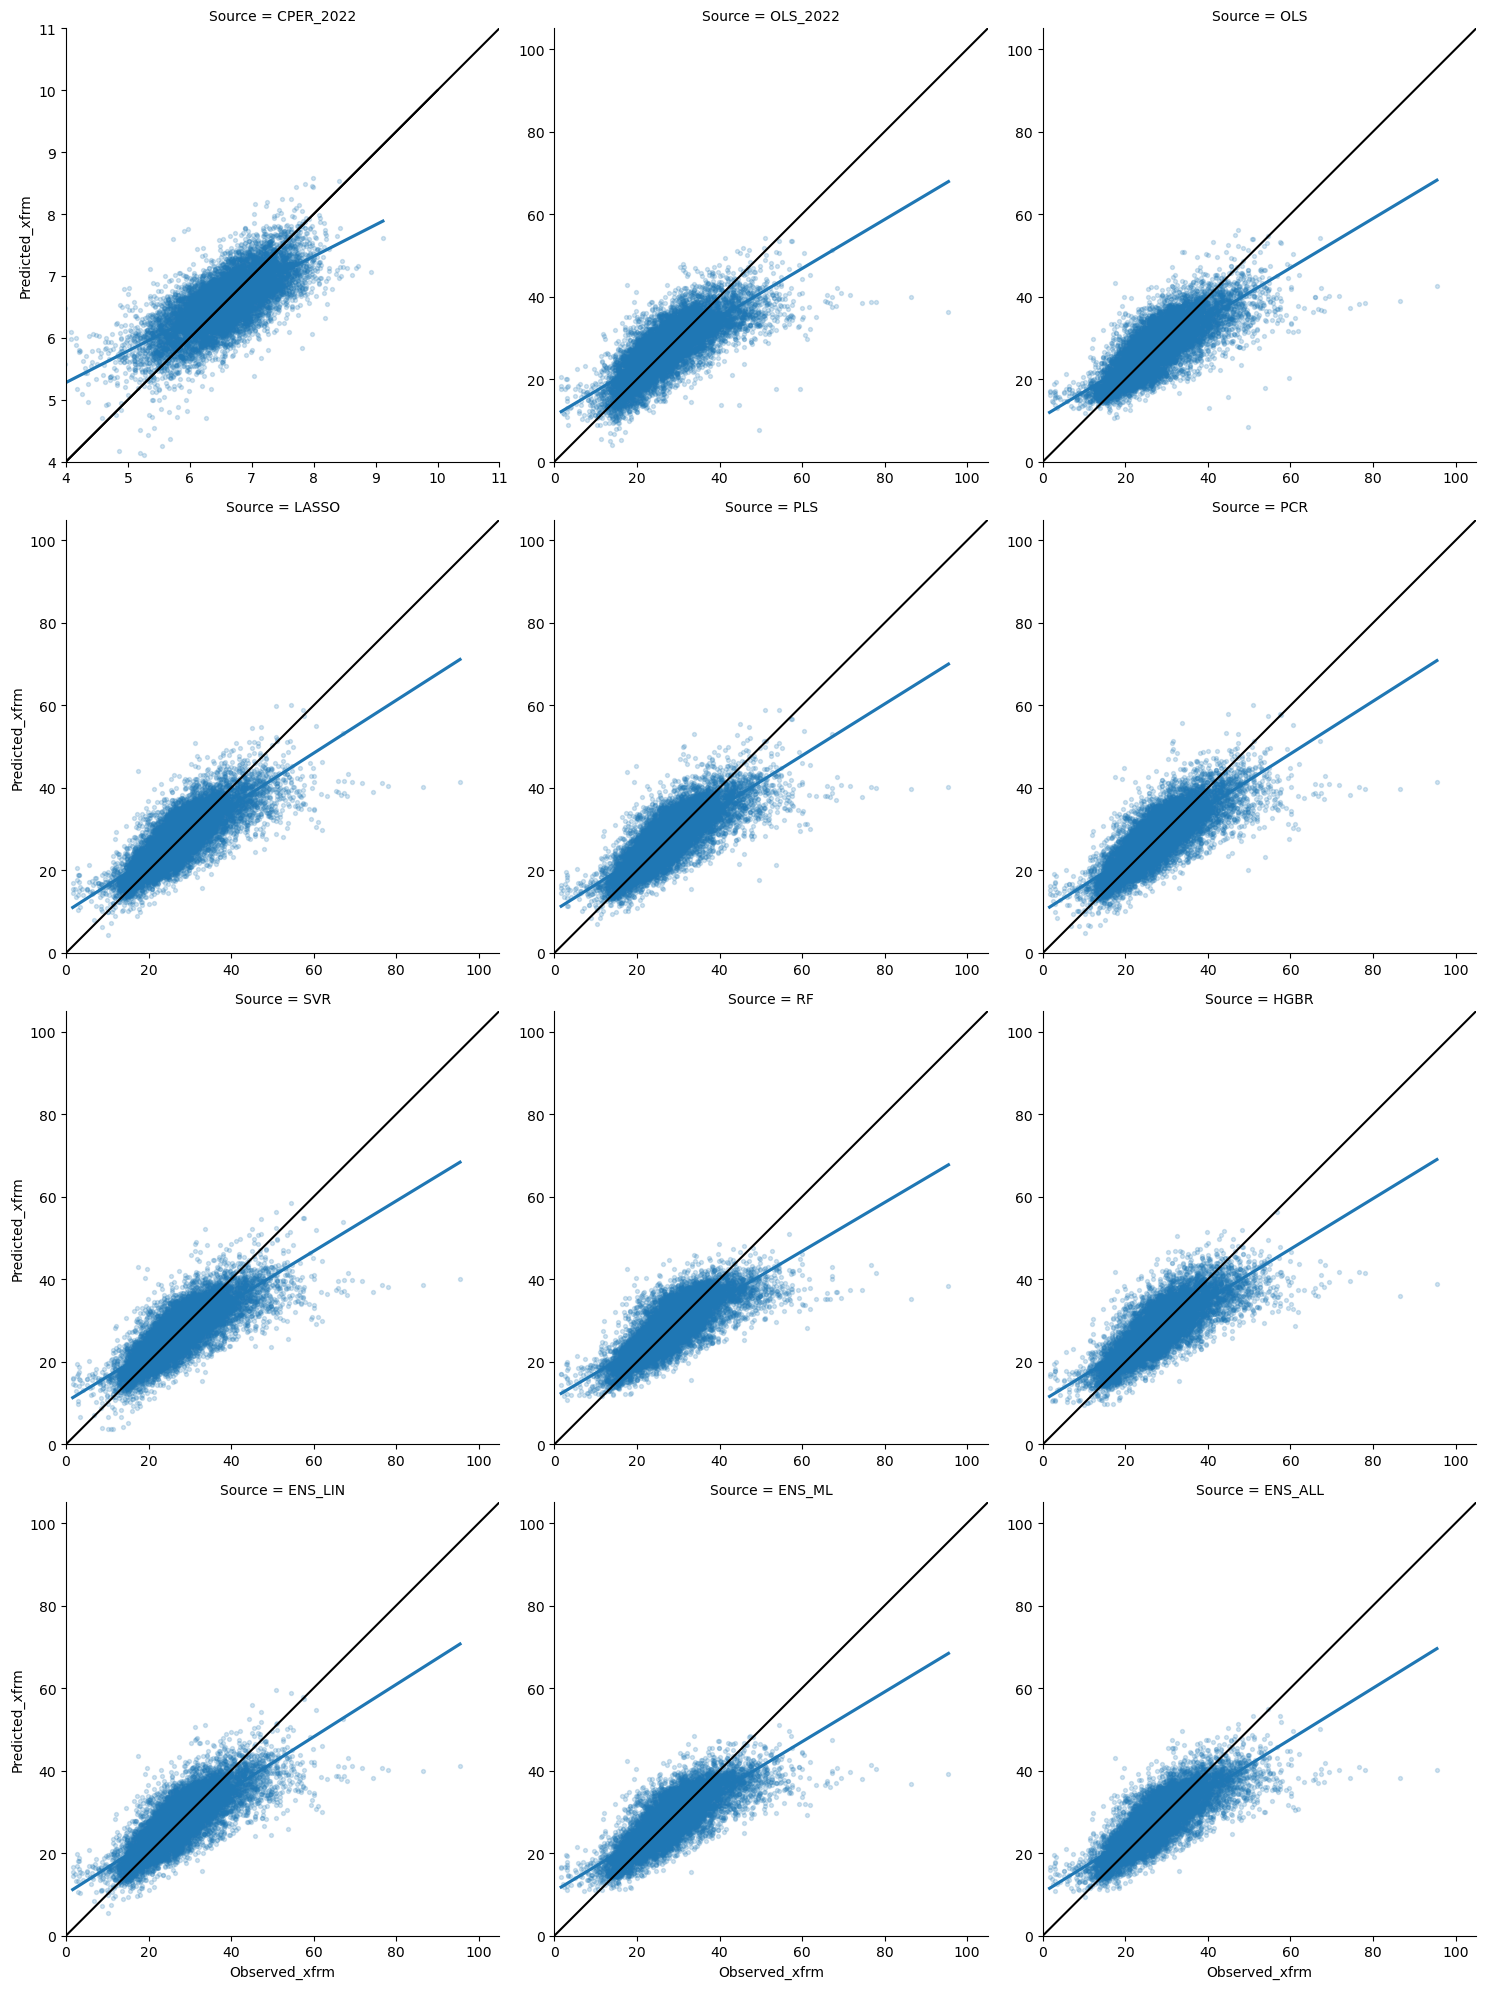

In [27]:
p_obs = sns.lmplot(df_bm_pred,
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3, ci=None,
                   facet_kws=dict(sharey=False, sharex=False,),
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_obs.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.set_xlim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_obs.axes[0].set_ylim((4, 11))
p_obs.axes[0].set_xlim((4, 11))
p_obs.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')

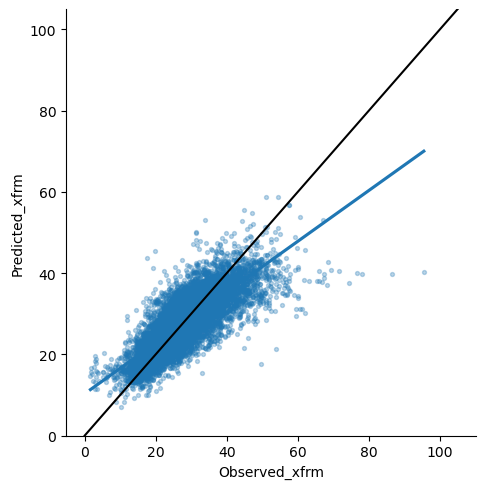

In [28]:
p_obs_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'],
               x='Observed_xfrm', y='Predicted_xfrm', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.3, 'edgecolor': None})
for ax in p_obs_best.axes.flatten():
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

## Get aggregated predictions

### Transect

MAE  MAE_std    Bias  Bias_std     R^2  R^2_std       r   r_std  \
Source                                                                          
CPER_2022  0.3614   0.0434  0.0021    0.1784 -0.1078   0.1151  0.2999  0.1181   
OLS_2022   4.3613   1.0252 -0.2149    1.1991  0.0996   0.1152  0.3904  0.1130   
OLS        4.2050   1.0264 -0.1484    0.6340  0.1425   0.1329  0.4017  0.1539   
LASSO      4.0389   1.0156  0.0415    0.4649  0.2268   0.0774  0.4857  0.0912   
PLS        4.1246   1.1084 -0.0589    0.4524  0.1963   0.1141  0.4526  0.1314   
PCR        4.1191   1.0916  0.0153    0.3522  0.1999   0.1058  0.4512  0.1251   
SVR        4.1086   1.0554 -0.5734    0.4603  0.1898   0.0937  0.4520  0.1199   
RF         4.1497   1.2319  0.0044    1.2714  0.1938   0.1403  0.4739  0.1314   
HGBR       4.1009   1.1622 -0.1096    0.7159  0.2097   0.1106  0.4716  0.1232   
ENS_LIN    4.0769   1.0686  0.0048    0.3964  0.2158   0.0932  0.4701  0.1111   
ENS_ML     4.0129   1.1170 -0.1990    0.6713  0.2372   0.1019  0.4978  0.1194   
ENS_ALL    4.0084   1.0770 -0.0883    0.4404  0.2393   0.0937  0.4951  0.1126   

             MAE_bt  MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  \
Source                                                                 
CPER_2022  293.3423    149.0594      0.3422          0.0263 -74.1300   
OLS_2022   261.6418    130.6195      0.3083          0.0398 -40.9539   
OLS        253.9012    125.9271      0.2969          0.0275 -42.4635   
LASSO      245.3231    126.3463      0.2850          0.0227 -26.8502   
PLS        250.7179    131.3781      0.2895          0.0255 -33.6241   
PCR        250.2261    131.0183      0.2894          0.0251 -27.5469   
SVR        249.1650    129.0259      0.2886          0.0241 -64.9728   
RF         253.5948    140.7173      0.2923          0.0409 -39.2722   
HGBR       250.3733    136.0775      0.2890          0.0350 -39.7814   
ENS_LIN    247.8277    129.2393      0.2867          0.0235 -29.3404   
ENS_ML     244.8896    131.2151      0.2822          0.0287 -48.0088   
ENS_ALL    244.1567    128.3972      0.2820          0.0252 -38.6746   

           Bias_bt_std  
Source                  
CPER_2022     152.6506  
OLS_2022       77.2617  
OLS            49.5640  
LASSO          35.6747  
PLS            38.1410  
PCR            27.7831  
SVR            49.3227  
RF             95.8777  
HGBR           54.1458  
ENS_LIN        32.7526  
ENS_ML         57.2096  
ENS_ALL        39.2830

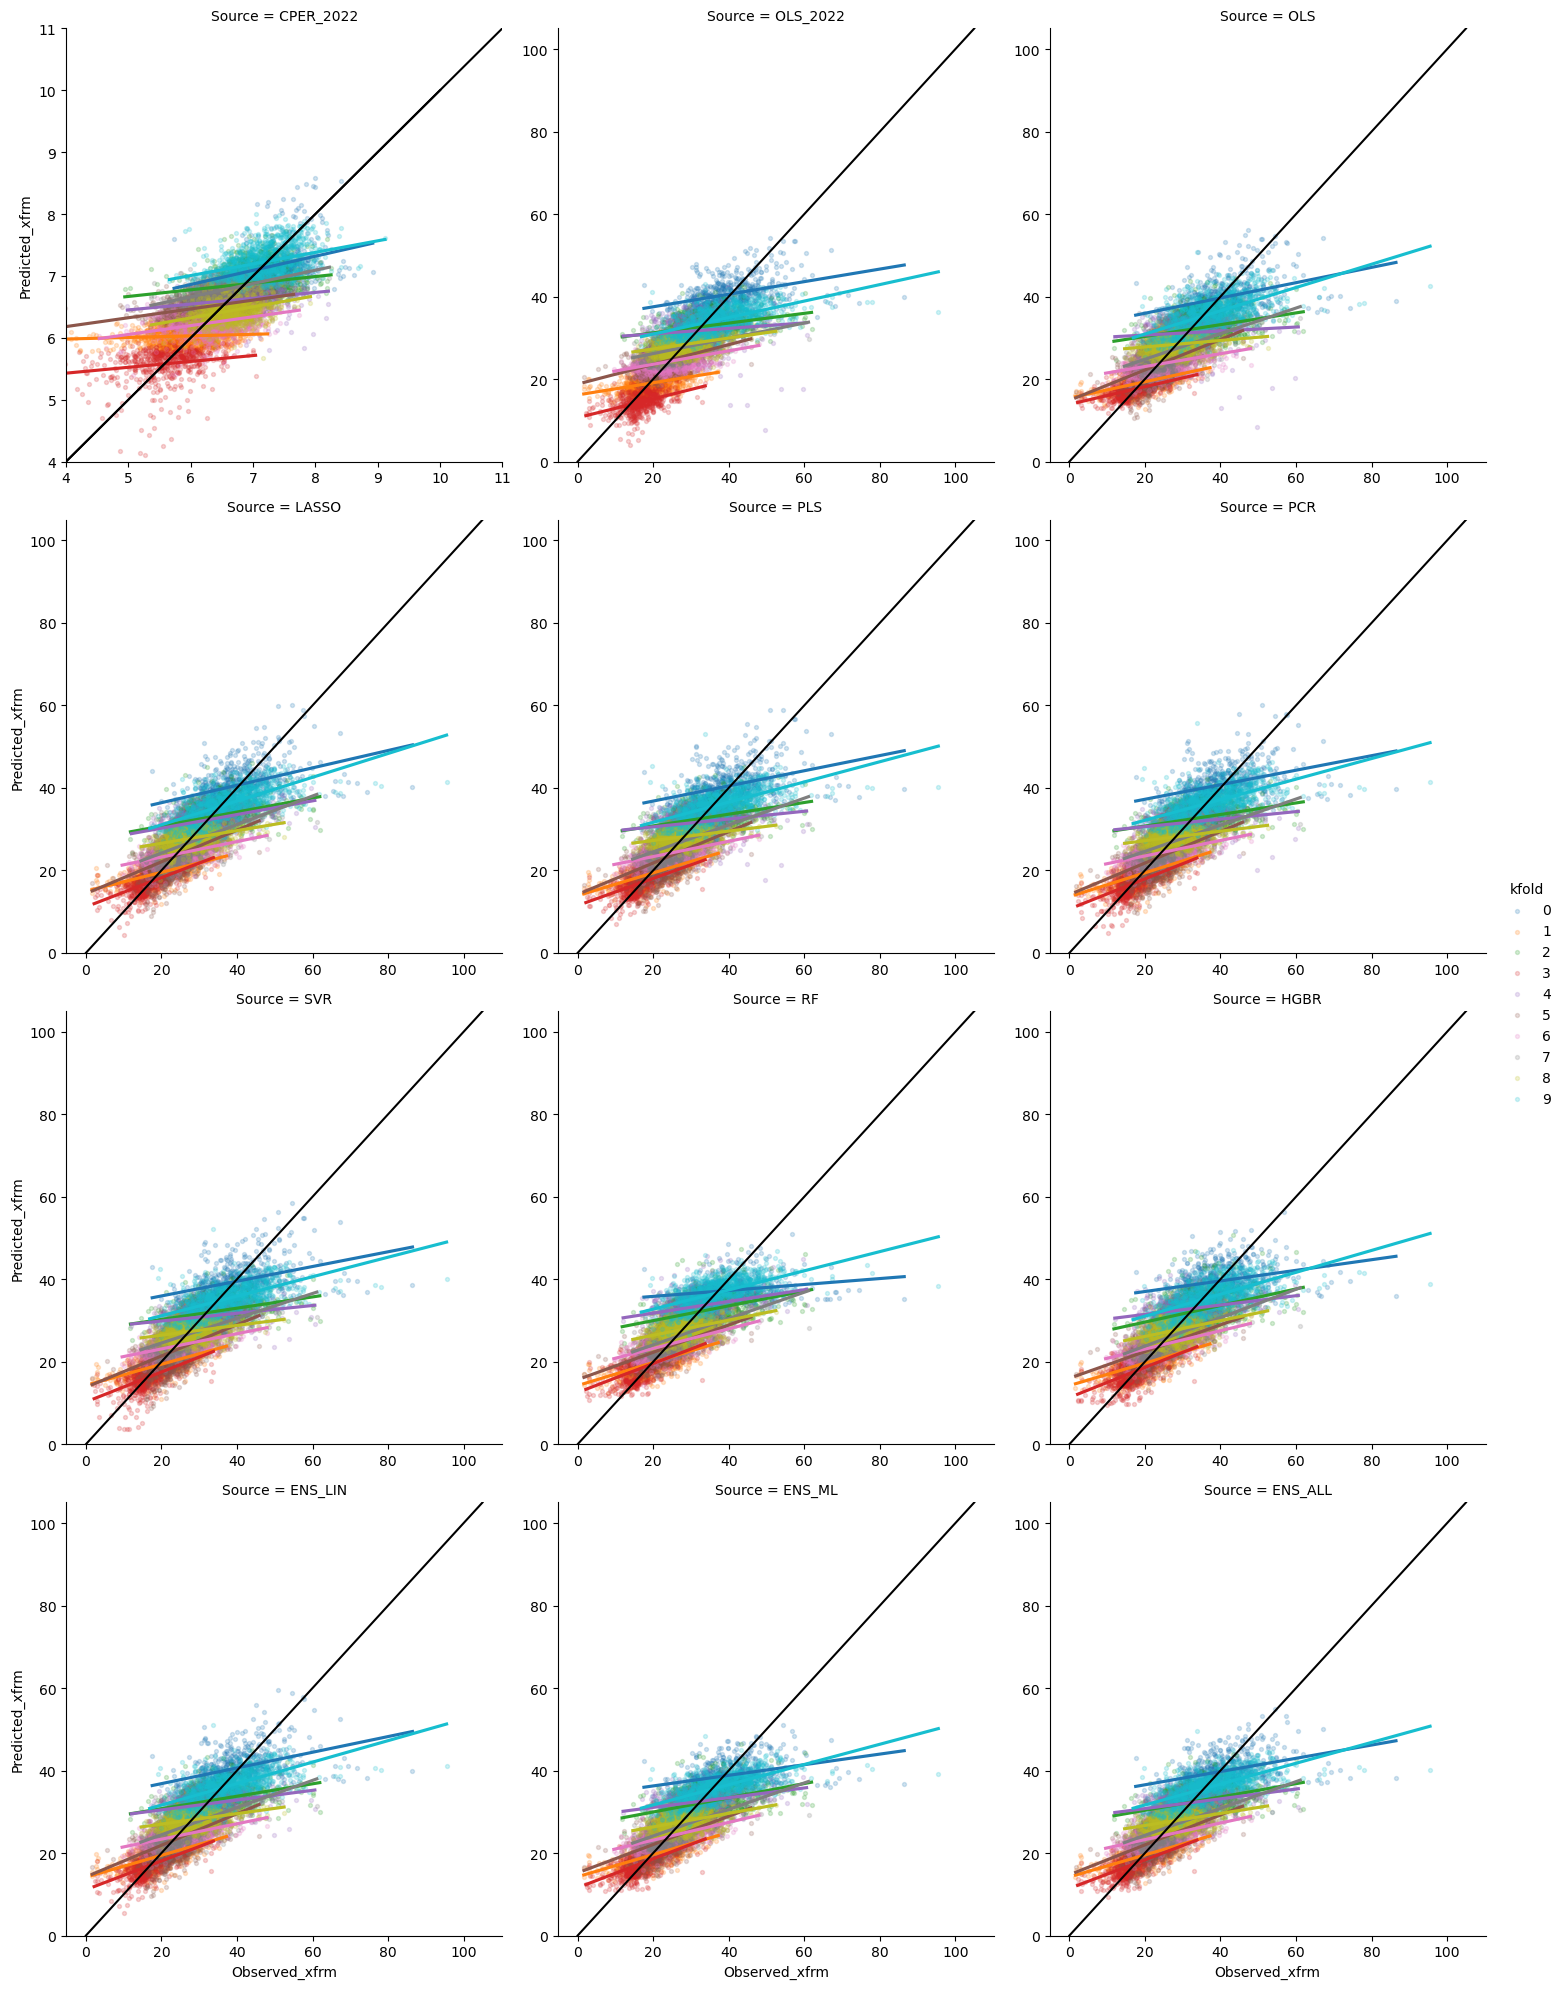

In [29]:
if 'transect' in inPATH:
    mae_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
            include_groups=False).mean(), include_groups=False).round(4)
    bias_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
            include_groups=False).mean(), include_groups=False).round(4)
    mae_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
            include_groups=False).mean(), include_groups=False).round(4)
    bias_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby([id_col, date_col]).apply(
            lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
            include_groups=False).mean(), include_groups=False).round(4)
    r2_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
        lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
        include_groups=False).round(4)
    r2_corr_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, past_col, date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
            lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
        include_groups=False).round(4)

    df_smry_transect = pd.DataFrame({
        'MAE': mae_transect.unstack(level=0).mean().round(4),
        'MAE_std': mae_transect.unstack(level=0).std().round(4),
        'Bias': bias_transect.unstack(level=0).mean().round(4),
        'Bias_std': bias_transect.unstack(level=0).std().round(4),
        'R^2': r2_transect.unstack(level=0).mean().round(4),
        'R^2_std': r2_transect.unstack(level=0).std().round(4),
        'r': r2_corr_transect.unstack(level=0).mean().round(4),
        'r_std': r2_corr_transect.unstack(level=0).std().round(4),
        'MAE_bt': mae_bt_transect.unstack(level=0).mean().round(4),
        'MAE_bt_std': mae_bt_transect.unstack(level=0).std().round(4),
        'MAE_bt_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
        'MAE_bt_pct_std': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
        'Bias_bt': bias_bt_transect.unstack(level=0).mean().round(4),
        'Bias_bt_std': bias_bt_transect.unstack(level=0).std().round(4),
    })
    display(df_smry_transect)
    if save_results:
        df_smry_transect.to_csv(os.path.join(outDIR,
                                             'tables/ml_models', 
                                             re.sub('tmp.csv', 'results_transect.csv', os.path.basename(inPATH))))
    
    df_smry_transect_by_yr = pd.DataFrame({
        'MAE': mae_transect.round(4),
        'Bias': bias_transect.round(4),
        'MAE_bt': mae_bt_transect.round(4),
        'MAE_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(4),
        'R^2': r2_transect.round(4),
        'r': r2_corr_transect.round(4)
    })
    #display(df_smry_transect_by_yr)
    if save_results:
        df_smry_transect_by_yr.to_csv(os.path.join(outDIR,
                                                   'tables/ml_models', 
                                                   re.sub('tmp.csv', 'results_transect_yrly.csv', os.path.basename(inPATH))))

    p_transect = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                           observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
                   x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                        facet_kws=dict(sharey=False, sharex=False,),
                        hue=logo_group, ci=None,
                        scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
    for ax in p_transect.axes:
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
    p_transect.axes[0].set_ylim((4, 11))
    p_transect.axes[0].set_xlim((4, 11))
    p_transect.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
    if save_results:
        plt.savefig(os.path.join(outDIR, 
                                 'figures/ml_models',
                                 re.sub('tmp.csv', 'results_transect.png', os.path.basename(inPATH))), dpi=100)

### Plot

In [30]:
mae_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
        include_groups=False).mean(), include_groups=False).round(4)
bias_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
        include_groups=False).mean(), include_groups=False).round(4)
mae_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
        include_groups=False).mean(), include_groups=False).round(4)
bias_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby(['Plot', date_col]).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
        include_groups=False).mean(), include_groups=False).round(4)
r2_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                             observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
    [mod_col, logo_group], observed=True).apply(
    lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
    include_groups=False).round(4)
r2_corr_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', past_col, date_col], 
                             observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
    [mod_col, logo_group], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
    include_groups=False).round(4)

In [31]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(4),
    'MAE_std': mae_plot.unstack(level=0).std().round(4),
    'Bias': bias_plot.unstack(level=0).mean().round(4),
    'Bias_std': bias_plot.unstack(level=0).std().round(4),
    'R^2': r2_plot.unstack(level=0).mean().round(4),
    'R^2_std': r2_plot.unstack(level=0).std().round(4),
    'r': r2_corr_plot.unstack(level=0).mean().round(4),
    'r_std': r2_corr_plot.unstack(level=0).std().round(4),
    'MAE_bt': mae_bt_plot.unstack(level=0).mean().round(4),
    'MAE_bt_std': mae_bt_plot.unstack(level=0).std().round(4),
    'MAE_bt_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
    'MAE_bt_pct_std': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
    'Bias_bt': bias_bt_plot.unstack(level=0).mean().round(4),
    'Bias_bt_std': bias_bt_plot.unstack(level=0).std().round(4),
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_plot.csv', os.path.basename(inPATH))))

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(4),
    'Bias': bias_plot.round(4),
    'MAE_bt': mae_bt_plot.round(4),
    'MAE_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(4),
    'R^2': r2_plot.round(4),
    'r': r2_corr_plot.round(4)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv(os.path.join(outDIR, 
                                           'tables/ml_models', 
                                           re.sub('tmp.csv', 'results_plot_yrly.csv', os.path.basename(inPATH))))

MAE  MAE_std    Bias  Bias_std     R^2  R^2_std       r   r_std  \
Source                                                                          
CPER_2022  0.3432   0.0448  0.0147    0.1708 -0.1159   0.1309  0.3194  0.1250   
OLS_2022   3.9791   0.8468 -0.0546    1.0750  0.1453   0.0898  0.4351  0.0941   
OLS        3.8133   0.8422 -0.0509    0.5583  0.1852   0.1262  0.4479  0.1421   
LASSO      3.6132   0.8512  0.1035    0.4017  0.2811   0.0831  0.5390  0.0849   
PLS        3.7228   0.9525  0.0376    0.3724  0.2428   0.1150  0.5015  0.1176   
PCR        3.7173   0.9468  0.0959    0.3221  0.2473   0.1095  0.4997  0.1134   
SVR        3.7063   0.9168 -0.4757    0.3511  0.2371   0.1034  0.4984  0.1114   
RF         3.6741   1.0638  0.0754    1.0603  0.2654   0.1365  0.5390  0.1237   
HGBR       3.5858   0.9448 -0.0468    0.4841  0.2932   0.1153  0.5453  0.1181   
ENS_LIN    3.6668   0.9141  0.0844    0.3359  0.2650   0.0962  0.5208  0.1002   
ENS_ML     3.5527   0.9430 -0.1230    0.4688  0.3009   0.1082  0.5580  0.1142   
ENS_ALL    3.5776   0.9135 -0.0108    0.2853  0.2950   0.0979  0.5502  0.1043   

             MAE_bt  MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  \
Source                                                                 
CPER_2022  280.6815    143.6074      0.3283          0.0285 -63.8827   
OLS_2022   239.0293    113.2594      0.2861          0.0454 -32.6359   
OLS        230.7004    109.0769      0.2731          0.0287 -37.0994   
LASSO      220.2706    109.8351      0.2584          0.0215 -23.4141   
PLS        227.2814    115.9797      0.2643          0.0221 -28.2262   
PCR        226.8576    115.4558      0.2641          0.0217 -23.4496   
SVR        226.5031    114.5030      0.2642          0.0225 -59.6047   
RF         225.4603    123.3116      0.2610          0.0353 -34.5626   
HGBR       219.5346    114.0699      0.2560          0.0296 -35.5980   
ENS_LIN    223.8558    113.3789      0.2610          0.0205 -25.0299   
ENS_ML     217.9462    113.6728      0.2531          0.0251 -43.2551   
ENS_ALL    218.8863    111.9637      0.2548          0.0224 -34.1425   

           Bias_bt_std  
Source                  
CPER_2022     141.1294  
OLS_2022       67.2762  
OLS            41.3615  
LASSO          30.8847  
PLS            30.9666  
PCR            23.2255  
SVR            40.2402  
RF             80.2706  
HGBR           37.8925  
ENS_LIN        27.1719  
ENS_ML         42.9808  
ENS_ALL        27.9659

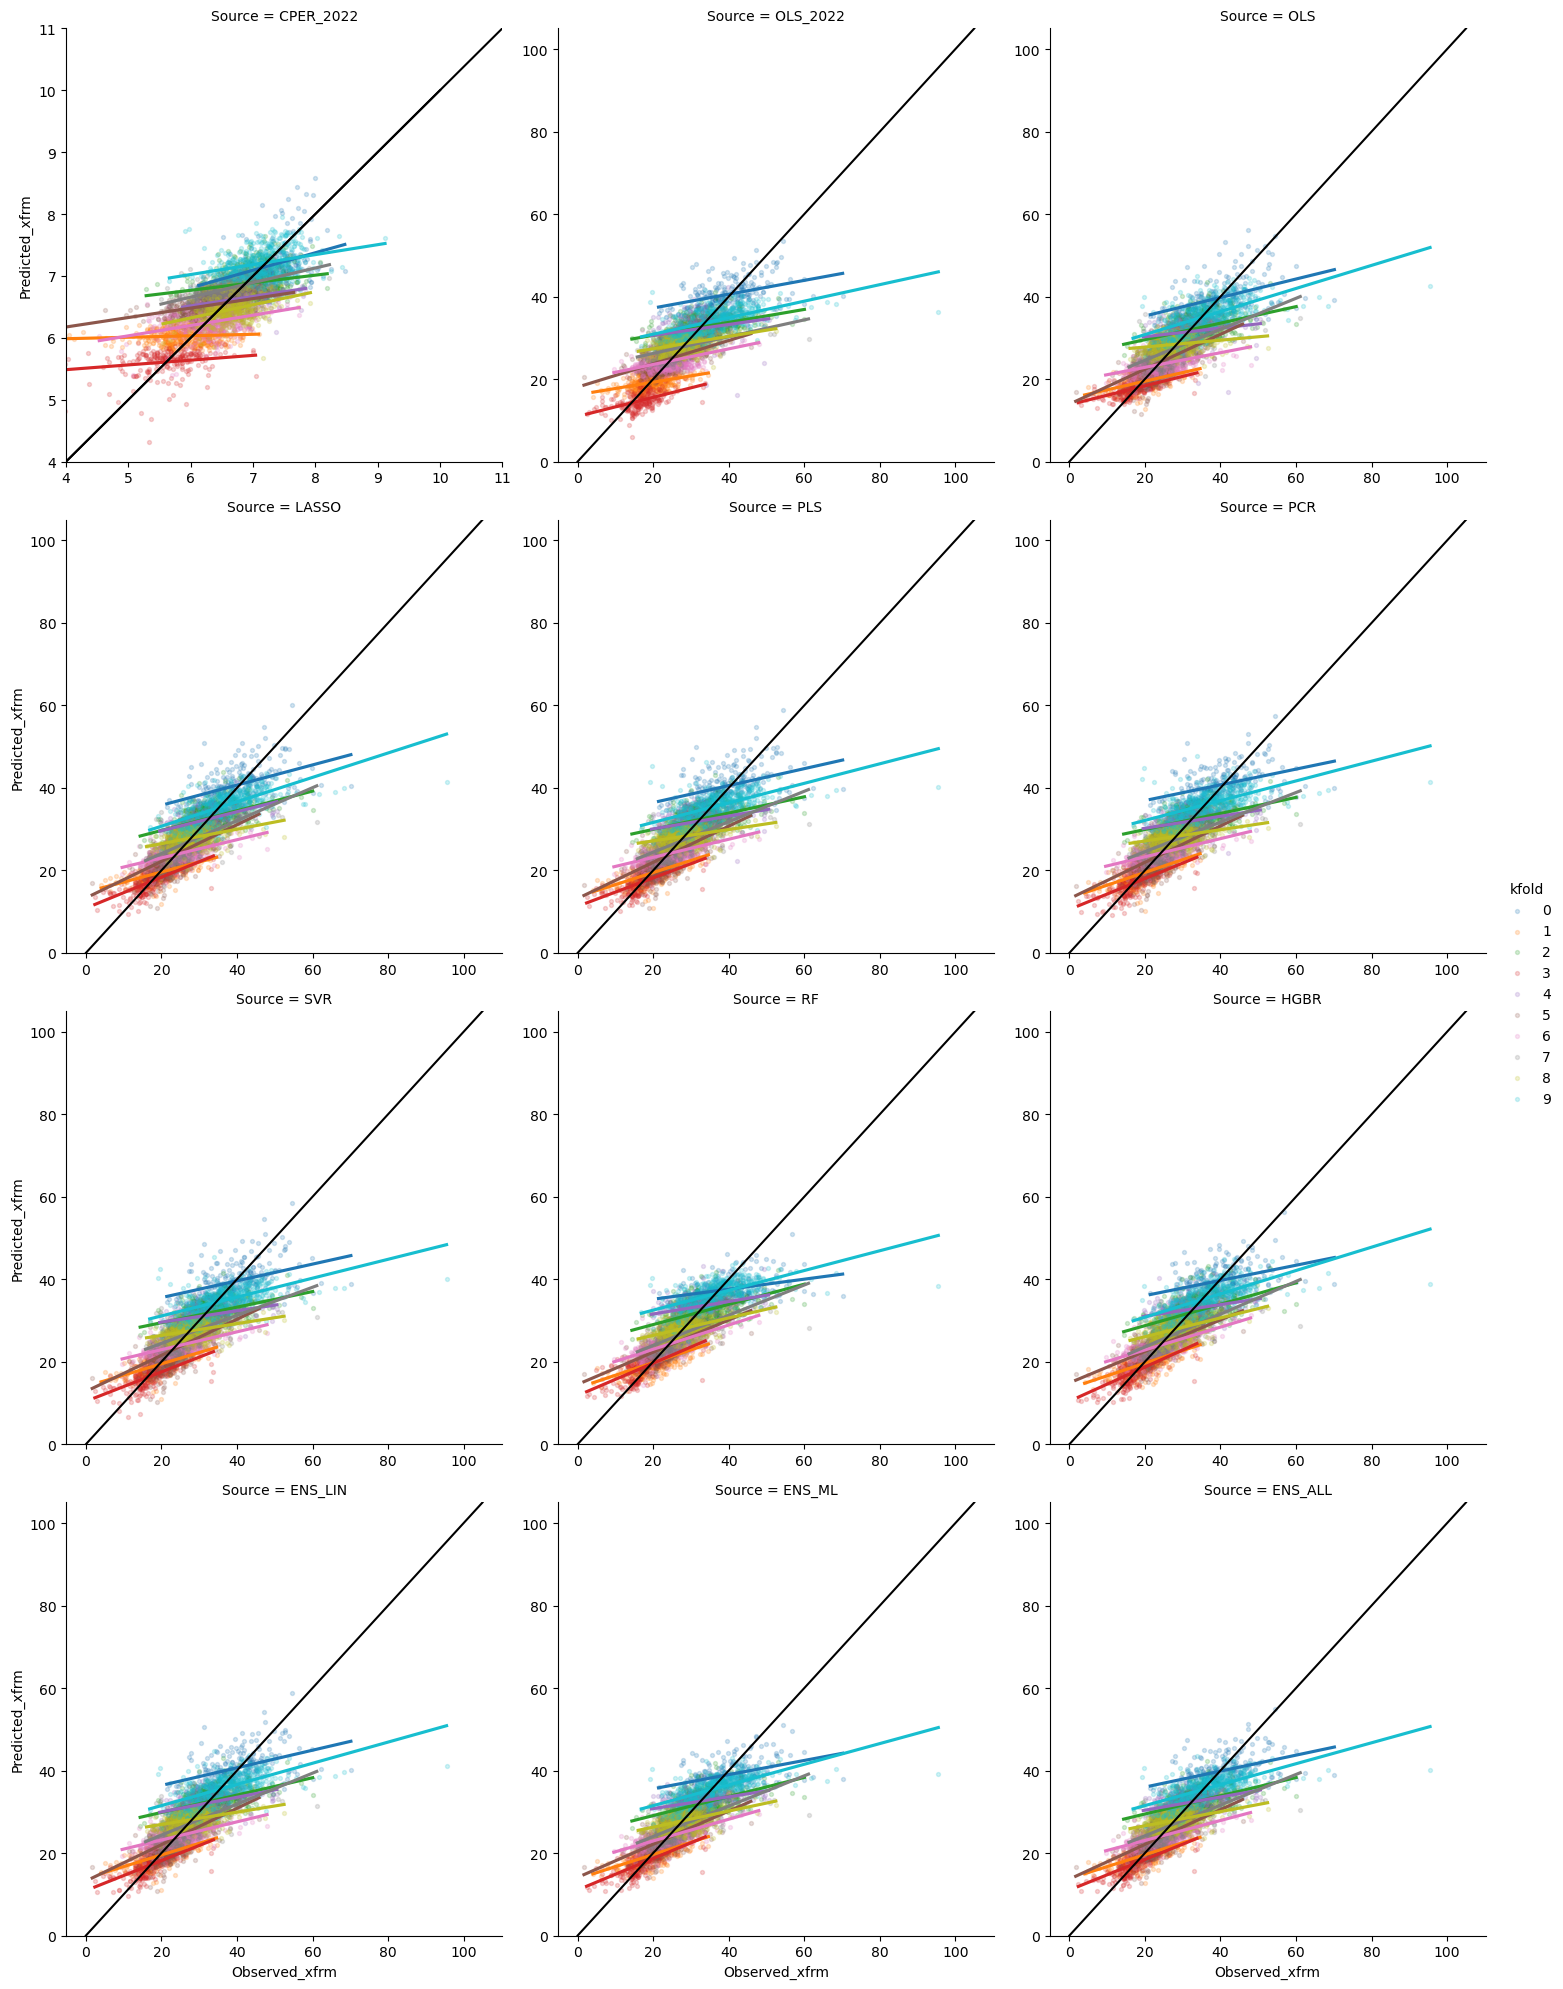

In [32]:
p_plot = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                                       observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_plot.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_plot.axes[0].set_ylim((4, 11))
p_plot.axes[0].set_xlim((4, 11))
p_plot.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'results_plot.png', os.path.basename(inPATH))), dpi=100)

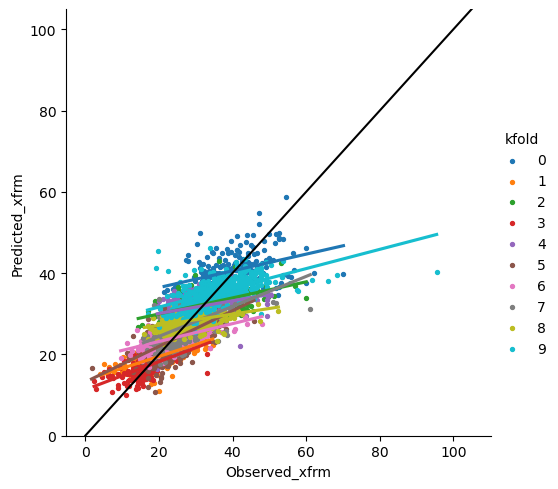

In [33]:
p_plot_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby([logo_group, 'Plot', date_col], 
                                       observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', ci=None, hue=logo_group,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_plot_best.axes.flatten():
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

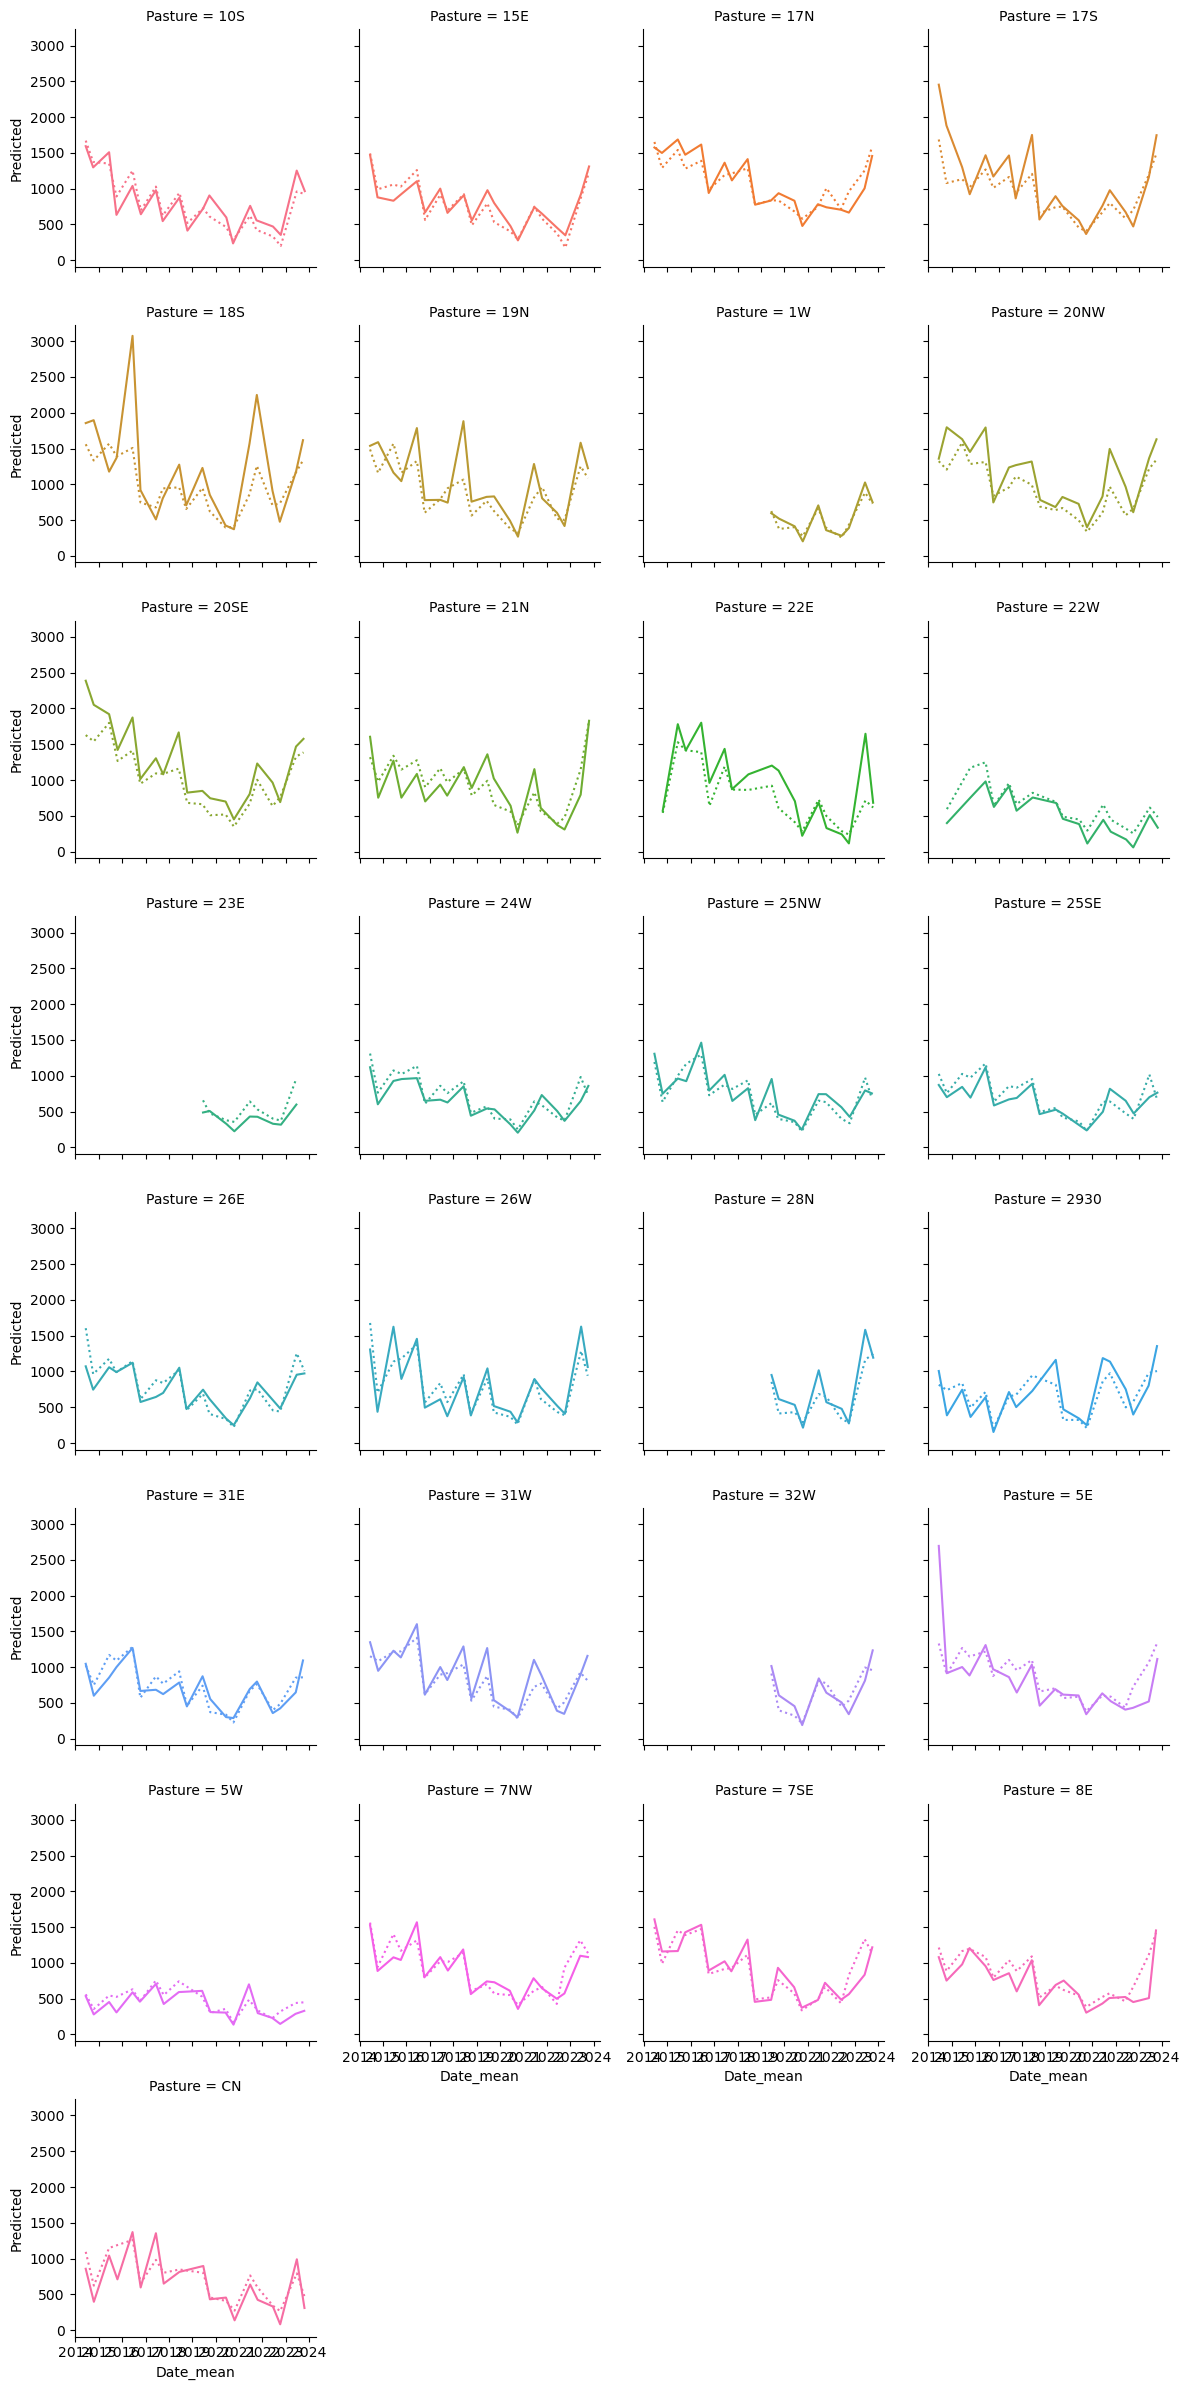

In [34]:
df_bm_pred[date_col] = pd.to_datetime(df_bm_pred[date_col])
df_bm_pred['DOY'] = df_bm_pred[date_col].dt.dayofyear
p_plot_ts_best = sns.FacetGrid(hue=past_col, 
                               data=df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby(
                                   [past_col, 'DOY', date_col], 
                                   observed=True)[['Observed', 'Predicted']].mean().reset_index().sort_values([past_col, date_col]),
                               col=past_col, col_wrap=4, sharex=True)
p_plot_ts_best.map(plt.plot, date_col, 'Observed', linestyle='solid')
p_plot_ts_best.map(plt.plot, date_col, 'Predicted', linestyle='dotted')

### Pasture

In [35]:
mae_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])),
                                                      include_groups=False).mean(), 
    include_groups=False).round(4)
bias_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
        include_groups=False).mean(), include_groups=False).round(4)
mae_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
        include_groups=False).mean(), include_groups=False).round(4)
bias_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
        include_groups=False).mean(), include_groups=False).round(4)
r2_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols, 
                                observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                                                observed=True).apply(
    lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
    include_groups=False).round(4)
r2_corr_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols,
                                     observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                          observed=True).apply(
    lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
    include_groups=False).round(4)

In [36]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(4),
    'MAE_std': mae_pasture.unstack(level=0).std().round(4),
    'Bias': bias_pasture.unstack(level=0).mean().round(4),
    'Bias_std': bias_pasture.unstack(level=0).std().round(4),
    'R^2': r2_pasture.unstack(level=0).mean().round(4),
    'R^2_std': r2_pasture.unstack(level=0).std().round(4),
    'r': r2_corr_pasture.unstack(level=0).mean().round(4),
    'r_std': r2_corr_pasture.unstack(level=0).std().round(4),
    'MAE_bt': mae_bt_pasture.unstack(level=0).mean().round(4),
    'MAE_bt_std': mae_bt_pasture.unstack(level=0).std().round(4),
    'MAE_bt_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
    'MAE_bt_pct_std': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
    'Bias_bt': bias_bt_pasture.unstack(level=0).mean().round(4),
    'Bias_bt_std': bias_bt_pasture.unstack(level=0).std().round(4),
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture.csv', os.path.basename(inPATH))))

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(4),
    'Bias': bias_pasture.round(4),
    'MAE_bt': mae_bt_pasture.round(4),
    'MAE_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, logo_group],
                                                    observed=True)['Observed'].mean()).round(4),
    'R^2': r2_pasture.round(4),
    'r': r2_corr_pasture.round(4)
})
#display(df_smry_pasture_by_yr.sort_values('r'))
if save_results:
    df_smry_pasture_by_yr.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture_yrly.csv', os.path.basename(inPATH))))

MAE  MAE_std    Bias  Bias_std     R^2  R^2_std       r   r_std  \
Source                                                                          
CPER_2022  0.3281   0.0389  0.0287    0.1570 -0.1622   0.1999  0.2998  0.1086   
OLS_2022   3.7074   0.8268  0.1638    1.0436  0.1675   0.1303  0.4744  0.1183   
OLS        3.5096   0.8251  0.0890    0.5020  0.2093   0.1455  0.4732  0.1510   
LASSO      3.3108   0.8192  0.2440    0.4375  0.3125   0.1071  0.5727  0.0923   
PLS        3.4416   0.9482  0.2112    0.4706  0.2647   0.1487  0.5310  0.1348   
PCR        3.4348   0.9473  0.2556    0.4999  0.2692   0.1378  0.5281  0.1280   
SVR        3.4126   0.9094 -0.2900    0.3578  0.2658   0.1345  0.5268  0.1327   
RF         3.2686   0.9600  0.1947    0.9521  0.3328   0.1493  0.6006  0.1356   
HGBR       3.1778   0.8875  0.0799    0.2998  0.3583   0.1541  0.6018  0.1484   
ENS_LIN    3.3774   0.9023  0.2427    0.4462  0.2908   0.1232  0.5520  0.1125   
ENS_ML     3.1910   0.8836  0.0210    0.3130  0.3557   0.1363  0.6066  0.1379   
ENS_ALL    3.2554   0.8774  0.1406    0.2532  0.3361   0.1243  0.5899  0.1232   

             MAE_bt  MAE_bt_std  MAE_bt_pct  MAE_bt_pct_std  Bias_bt  \
Source                                                                 
CPER_2022  270.6792    143.7621      0.3367          0.0839 -44.2351   
OLS_2022   221.5532    104.4276      0.2845          0.0781 -17.0850   
OLS        211.6363    100.3364      0.2685          0.0667 -25.7869   
LASSO      201.4756    101.5465      0.2533          0.0621 -11.7847   
PLS        209.7584    109.0210      0.2607          0.0651 -14.4532   
PCR        209.3042    108.4885      0.2602          0.0644 -11.0896   
SVR        208.5831    106.7156      0.2603          0.0650 -45.6040   
RF         199.4591    108.4668      0.2476          0.0664 -25.0192   
HGBR       194.3297    101.5220      0.2425          0.0625 -24.8316   
ENS_LIN    205.8238    105.9980      0.2565          0.0630 -12.4425   
ENS_ML     195.1489    101.5447      0.2433          0.0622 -31.8182   
ENS_ALL    198.4267    102.0481      0.2476          0.0618 -22.1304   

           Bias_bt_std  
Source                  
CPER_2022     126.4806  
OLS_2022       56.4049  
OLS            33.0727  
LASSO          32.2465  
PLS            31.4552  
PCR            30.1831  
SVR            29.6701  
RF             71.7033  
HGBR           19.5071  
ENS_LIN        29.9873  
ENS_ML         26.9870  
ENS_ALL        15.4938

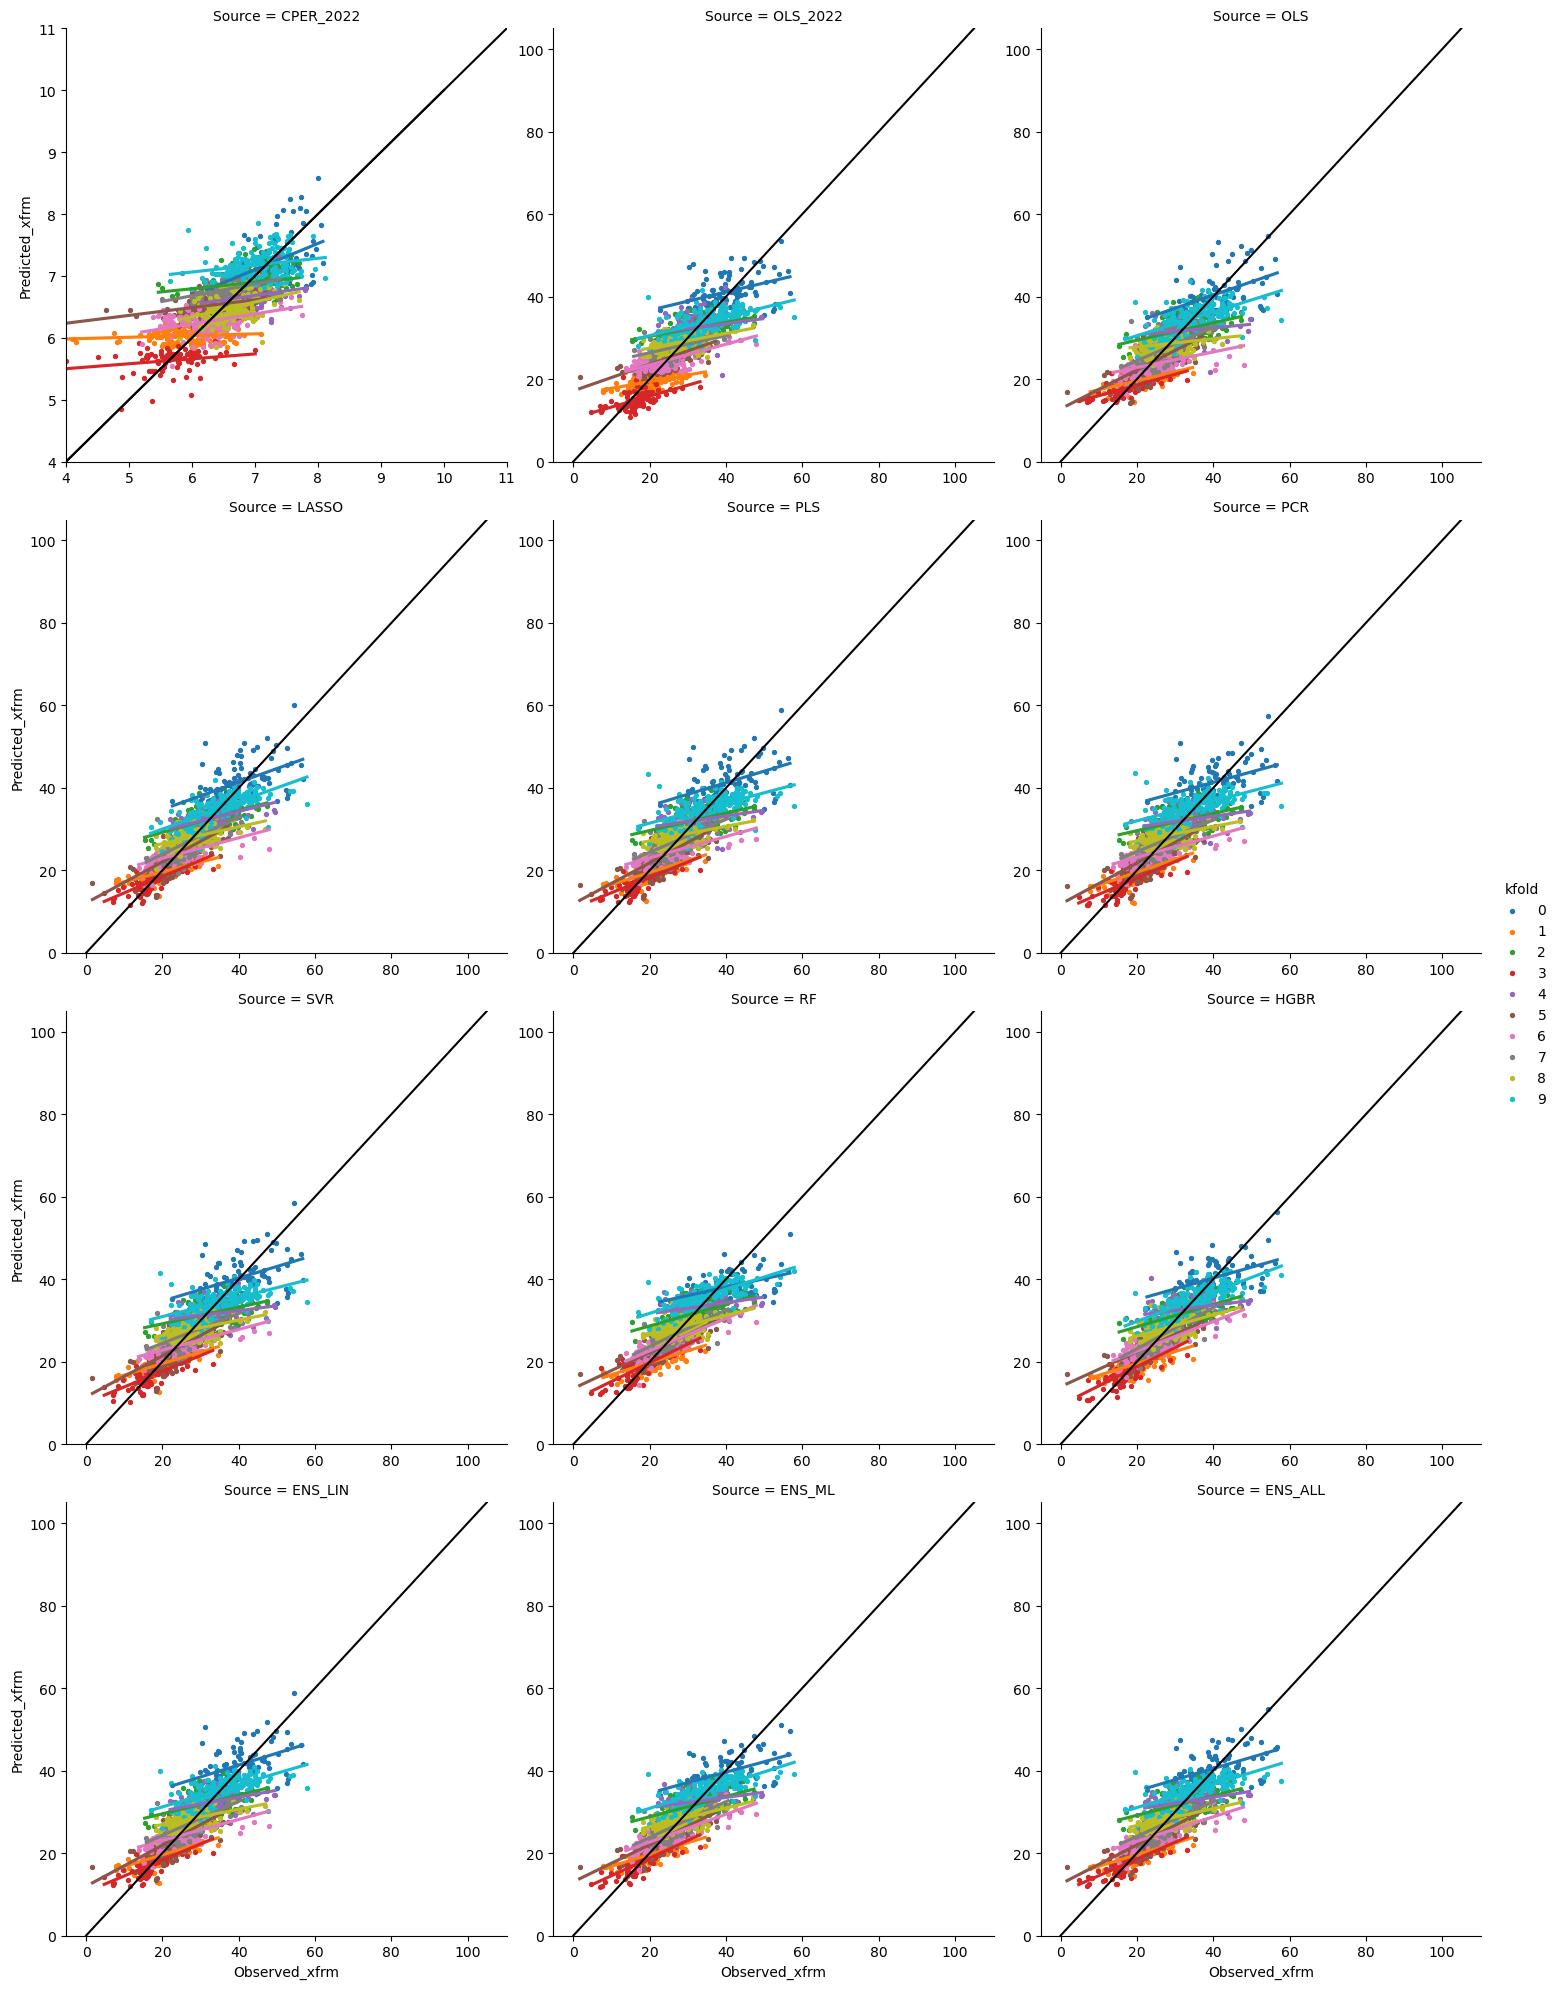

In [37]:
p_past = sns.lmplot(df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols)),
                                      observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_past.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_past.axes[0].set_ylim((4, 11))
p_past.axes[0].set_xlim((4, 11))
p_past.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'results_pasture.png', os.path.basename(inPATH))), dpi=100)

## Extra plots (not currently used)

In [40]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)
else:
    p_trans=None

In [41]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

/local/scratch/sean.kearney/16107206/ipykernel_2918297/3509725408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Season', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_pasture_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean', 'Season']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Season', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture_seas.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

## Make variable importance dataframes

In [39]:
df_ols = mod_dict['OLS']['formula_df']

In [40]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [41]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['kfold', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['kfold'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['kfold'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(kfold=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

2014


  0%|          | 0/28 [00:00<?, ?it/s]/local/scratch/sean.kearney/16301936/ipykernel_438907/2421960830.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])
100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


2015


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


2016


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


2017


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


2018


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


2019


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


2020


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


2021


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


2022


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


2023


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


In [42]:
def feature_type(f):
    if f in ['RED', 'GREEN', 'BLUE', 'NIR', 'SWIR1', 'SWIR2']:
        return 'Band'
    elif 'BAI' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['kfold',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_norm'] = df_ols_feats_grp.groupby('kfold')['RVIw'].transform(lambda x: x / x.mean())
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [43]:
df_ols_feats_grp['kfold'] = df_ols_feats_grp['kfold'].astype('str')
if kfold_group == 'Year':
    df_ols_feats_grp['kfold'] = pd.Categorical(df_ols_feats_grp['kfold'], 
                                               [str(x) for x in range(min(df_ols_feats_grp['kfold'].astype(int)),
                                                                      max(df_ols_feats_grp['kfold'].astype(int))+1)])

In [44]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['kfold'] = pd.Categorical(df_lasso_coefs['kfold'], categories=df_lasso_coefs['kfold'].sort_values().unique())
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable', observed=True)['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs['Coef_norm'] = df_lasso_coefs.groupby('kfold', observed=True)['Coef_abs'].transform(lambda x: x / x.mean())

dfs_lasso = []
for k in df_lasso_coefs['kfold'].unique():
    dfs_lasso_tmp = pd.DataFrame(data={'Variable': df_ols_feats_grp['features'].unique()})
    dfs_lasso_tmp['kfold'] = k
    dfs_lasso.append(dfs_lasso_tmp)
df_lasso_coefs_all = pd.concat(dfs_lasso)
df_lasso_coefs_all['Coef_abs_sum'] = 0.0
for k in df_lasso_coefs_all['kfold'].unique(): 
    for i in df_lasso_coefs_all['Variable']:
        df_lasso_coefs_all.loc[(df_lasso_coefs_all['Variable'] == i) & 
        (df_lasso_coefs_all['kfold'] == k),
        'Coef_abs_sum'] = df_lasso_coefs[df_lasso_coefs['kfold'] == k][[i in x for x in df_lasso_coefs[df_lasso_coefs['kfold'] == k]['Variable']]]['Coef_abs'].sum()
df_lasso_coefs_all['kfold'] = pd.Categorical(df_lasso_coefs_all['kfold'], categories=df_lasso_coefs_all['kfold'].sort_values().unique())
df_lasso_coefs_ranked = df_lasso_coefs_all.groupby('Variable', observed=True)['Coef_abs_sum'].mean().sort_values(ascending=False)
df_lasso_coefs_all['Variable'] = pd.Categorical(df_lasso_coefs_all['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs_all['Coef_norm'] = df_lasso_coefs_all.groupby('kfold', observed=True)['Coef_abs_sum'].transform(lambda x: x / x.mean()) 

In [45]:
df_pls_coefs = mod_dict['PLS']['variable_df']
df_pls_coefs['kfold'] = pd.Categorical(df_pls_coefs['kfold'], categories=df_pls_coefs['kfold'].sort_values().unique())
df_pls_coefs_ranked = df_pls_coefs.groupby('Variable', observed=True)['VIP'].mean().sort_values(ascending=False)
df_pls_coefs['Variable'] = pd.Categorical(df_pls_coefs['Variable'], categories=df_pls_coefs_ranked.index.values)
df_pls_coefs_top = df_pls_coefs[df_pls_coefs['VIP'] > 1.0].copy()
df_pls_coefs_top['Variable'] = df_pls_coefs_top['Variable'].cat.remove_unused_categories()

In [46]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
df_pcr_coefs['kfold'] = pd.Categorical(df_pcr_coefs['kfold'], categories=df_pcr_coefs['kfold'].sort_values().unique())
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['kfold', 'Variable'], observed=True).apply(lambda x: np.mean(np.abs(x), axis=1),
                                                                                     include_groups=False)
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

df_pcr_coefs_mean['Coef_mean_norm'] = df_pcr_coefs_mean.groupby('kfold', observed=True)['Coef_mean_abs'].transform(lambda x: x / x.mean())
pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable', observed=True)['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

In [47]:
df_svr_wts = mod_dict['SVR']['variable_df'].copy()
df_svr_wts['kfold'] = pd.Categorical(df_svr_wts['kfold'], categories=df_svr_wts['kfold'].sort_values().unique())
df_svr_wts['SVR_weights_abs'] = df_svr_wts['SVR_weights'].transform(lambda x: abs(x))
df_svr_wts['SVR_weights_norm'] = df_svr_wts.groupby('kfold', observed=True)['SVR_weights_abs'].transform(lambda x: x / x.mean())
df_svr_wts_ranked = df_svr_wts.groupby('Variable', observed=True)['SVR_weights_abs'].mean().sort_values(ascending=False)
df_svr_wts['Variable'] = pd.Categorical(df_svr_wts['Variable'], categories=df_svr_wts_ranked.index.values)

In [48]:
df_rf_mdi = mod_dict['RF']['variable_df'].copy()
df_rf_mdi['kfold'] = pd.Categorical(df_rf_mdi['kfold'], categories=df_rf_mdi['kfold'].sort_values().unique())
df_rf_mdi['MDI_norm'] = df_rf_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
df_rf_mdi_ranked = df_rf_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
df_rf_mdi['Variable'] = pd.Categorical(df_rf_mdi['Variable'], categories=df_rf_mdi_ranked.index.values)

In [49]:
#df_gbr_mdi = mod_dict['GBR']['variable_df'].copy()
#df_gbr_mdi['kfold'] = pd.Categorical(df_gbr_mdi['kfold'], categories=df_gbr_mdi['kfold'].sort_values().unique())
#df_gbr_mdi['MDI_norm'] = df_gbr_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
#df_gbr_mdi_ranked = df_gbr_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
#df_gbr_mdi['Variable'] = pd.Categorical(df_gbr_mdi['Variable'], categories=df_gbr_mdi_ranked.index.values)

In [50]:
df_hgbr_pi = mod_dict['HGBR']['variable_df'].copy()
df_hgbr_pi['kfold'] = pd.Categorical(df_hgbr_pi['kfold'], categories=df_hgbr_pi['kfold'].sort_values().unique())
df_hgbr_pi['PI_norm'] = df_hgbr_pi.groupby('kfold', observed=True)['PI'].transform(lambda x: x / x.mean())
df_hgbr_pi_ranked = df_hgbr_pi.groupby('Variable', observed=True)['PI_norm'].mean().sort_values(ascending=False)
df_hgbr_pi['Variable'] = pd.Categorical(df_hgbr_pi['Variable'], categories=df_hgbr_pi_ranked.index.values)

In [51]:
df_ols_feats_grp['Model'] = 'OLS'
df_ols_feats_grp['VI'] = df_ols_feats_grp['RVIw_norm']
df_ols_feats_grp['Variable'] = df_ols_feats_grp['features']

df_lasso_coefs_all['Model'] = 'LASSO'
df_lasso_coefs_all['VI'] = df_lasso_coefs_all['Coef_norm']

df_pls_coefs['Model'] = 'PLS'
df_pls_coefs['VI'] = df_pls_coefs['VIP']

df_pcr_coefs_mean['Model'] = 'PCR'
df_pcr_coefs_mean['VI'] = df_pcr_coefs_mean['Coef_mean_norm']

df_svr_wts['Model'] = 'SVR'
df_svr_wts['VI'] = df_svr_wts['SVR_weights_norm']

df_rf_mdi['Model'] = 'RF'
df_rf_mdi['VI'] = df_rf_mdi['MDI_norm']

#df_gbr_mdi['Model'] = 'GBR'
#df_gbr_mdi['VI'] = df_gbr_mdi['MDI_norm']

df_hgbr_pi['Model'] = 'HGBR'
df_hgbr_pi['VI'] = df_hgbr_pi['PI_norm']

vi_cols_list = ['Model','kfold', 'Variable', 'VI']

df_vi_all = pd.concat([df_lasso_coefs_all[vi_cols_list],
                       df_pls_coefs[vi_cols_list],
                       df_pcr_coefs_mean[vi_cols_list],
                       df_svr_wts[vi_cols_list],
                       df_rf_mdi[vi_cols_list],
                       #df_gbr_mdi[vi_cols_list],
                       df_hgbr_pi[vi_cols_list]])
df_vi_all = df_vi_all.reset_index(drop=True)

### Variable importance plots

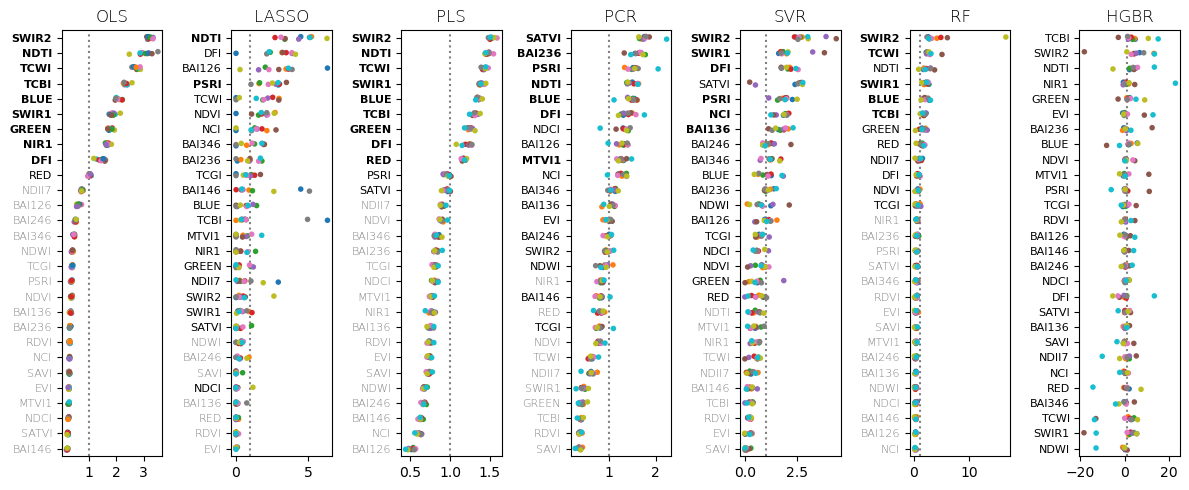

In [54]:
fig, axs = plt.subplots(ncols=7, nrows=1, figsize=(12, 5), 
                        sharex=False, sharey=False)
for idx, df_tmp in enumerate([df_ols_feats_grp,
                              df_lasso_coefs_all,
                              df_pls_coefs,
                              df_pcr_coefs_mean,
                              df_svr_wts,
                              df_rf_mdi,
                              df_hgbr_pi]):
    df_tmp['Variable'] = df_tmp['Variable'].apply(lambda x: re.sub('_', '', x))
    #top_vars = [x for x in df_tmp['Variable'].unique() if df_tmp[df_tmp['Variable'] == x]['VI'].mean() >= 1.0]
    top_vars = [x for x in df_tmp['Variable'].unique() if np.all(df_tmp[df_tmp['Variable'] == x]['VI'] >= 1.0)]
    #bottom_vars = [x for x in df_tmp['Variable'].unique() if df_tmp[df_tmp['Variable'] == x]['VI'].mean() < 1.0]
    bottom_vars = [x for x in df_tmp['Variable'].unique() if np.all(df_tmp[df_tmp['Variable'] == x]['VI'] < 1.0)]
    sns.stripplot(y='Variable', x='VI', data=df_tmp, size=4,
                  hue='kfold', orient='h',
                  ax=axs.flatten()[idx], legend=False)
    for ytick in axs.flatten()[idx].get_yticklabels():
        if ytick.get_text() in top_vars:
            ytick.set_fontweight(800)
        elif ytick.get_text() in bottom_vars:
            ytick.set_fontweight(100)
            ytick.set_color('grey')
    axs.flatten()[idx].yaxis.set_tick_params(labelsize=8)
    axs.flatten()[idx].axvline(x=1.0, linestyle='dotted', color='grey')
    axs.flatten()[idx].set_title(df_tmp['Model'].unique()[0], fontweight=10)
    #if idx > 3:
    #    axs.flatten()[idx].set_xlabel('Variable importance')
    #else:
    axs.flatten()[idx].set_xlabel(None)
    axs.flatten()[idx].set_ylabel(None)
plt.tight_layout()
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'vi_all.png', os.path.basename(inPATH))), dpi=100)

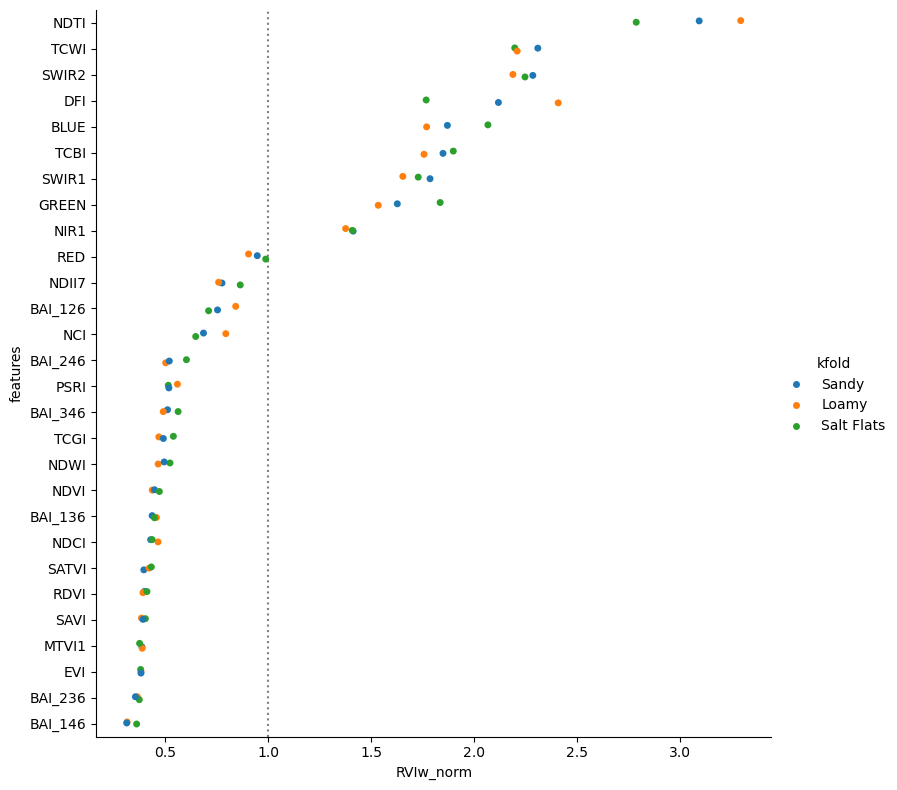

In [86]:
p = sns.catplot(y='features', x='RVIw_norm', hue='kfold',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#if save_results:
#    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_ols.png', os.path.basename(inPATH))), dpi=100)

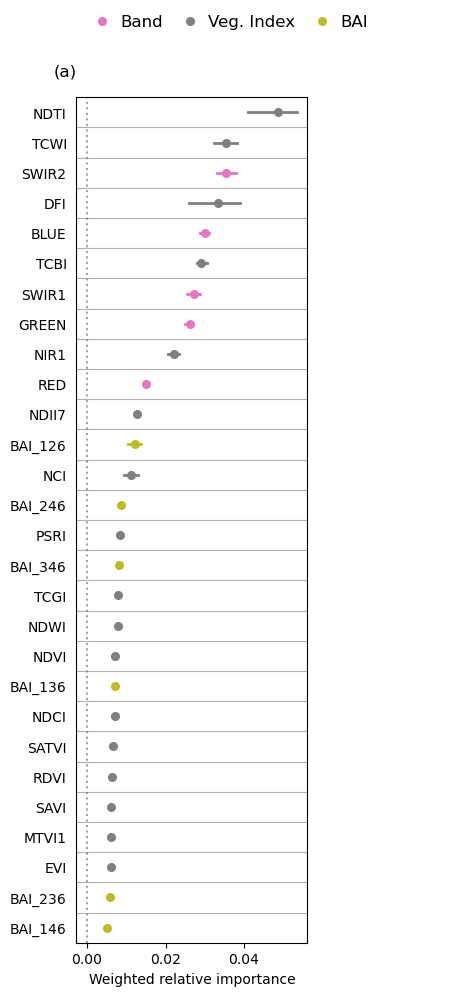

In [87]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [ ]:
p = sns.catplot(df_lasso_coefs_all, x='Coef_norm', y='Variable', hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [ ]:
p = sns.catplot(df_pls_coefs, x='VIP', y='Variable',  hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_pcr_coefs_mean,
                x='Coef_mean_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_svr_wts,
                x='SVR_weights_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_svr.png', os.path.basename(inPATH))), dpi=100)

In [94]:
df_svr_wts.groupby('Variable', observed=True)['SVR_weights_norm'].mean()

Variable
SWIR2      3.248787
SWIR1      2.497594
BAI_136    1.827635
NCI        1.629908
NDVI       1.508274
DFI        1.335951
NDWI       1.319505
BAI_346    1.346744
GREEN      1.211063
BLUE       1.172355
PSRI       1.150184
NDCI       1.038067
BAI_126    1.055384
SATVI      0.929783
BAI_236    0.834357
NDTI       0.819090
TCGI       0.726233
BAI_246    0.652782
BAI_146    0.590613
EVI        0.525799
NDII7      0.511270
TCWI       0.523419
RED        0.451092
RDVI       0.442271
SAVI       0.302825
MTVI1      0.130662
NIR1       0.113749
TCBI       0.104606
Name: SVR_weights_norm, dtype: float64

In [ ]:
p = sns.catplot(df_rf_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_rf.png', os.path.basename(inPATH))), dpi=100)

In [ ]:
p = sns.catplot(df_gbr_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_gbr.png', os.path.basename(inPATH))), dpi=100)

## Make parameter tuning dataframes

In [55]:
param_dfs = {}
for k in mod_dict:
    if 'tune_results' in mod_dict[k].keys():
        for idx, kfold in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][kfold]['params']]))
                #param_dfs[k] = pd.DataFrame(columns=['Model', 'kfold', 'Best', 'MAE'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'kfold': str(kfold),
                                   'Best': 0,
                                   'MAE': mod_dict[k]['tune_results'][kfold]['mean_test_MAE'],
                                   #'R2': mod_dict[k]['tune_results'][kfold]['mean_test_R2'],
                                   #'R2_train': mod_dict[k]['tune_results'][kfold]['mean_train_R2']
                                  })
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][kfold]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][kfold]['rank_test_MAE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            if idx == 0:
                param_dfs[k] = df_tmp
            else:
                param_dfs[k] = pd.concat([param_dfs[k], df_tmp.dropna(how='all', axis=0)])
        if k in param_dfs.keys():
            param_dfs[k] = param_dfs[k].reset_index(drop=True)

In [113]:
param_dfs['PCR']

Model kfold  Best       MAE pca__n_components
0     PCR  2014     0 -5.987544                 1
1     PCR  2014     0 -5.208924                 2
2     PCR  2014     0 -4.376159                 3
3     PCR  2014     0 -4.349545                 4
4     PCR  2014     0 -4.304866                 5
..    ...   ...   ...       ...               ...
125   PCR  2023     0 -4.247566                 9
126   PCR  2023     0 -4.168809                10
127   PCR  2023     1 -4.105374                11
128   PCR  2023     0 -4.107210                12
129   PCR  2023     0 -4.105788                13

[130 rows x 5 columns]

In [134]:
param_dict = {
    'LASSO_1': 'LASSO__alpha',
    'PLS_1': 'PLS__n_components',
    'PCR_1': 'pca__n_components',
    'SVR_1': 'SVR__C',
    'SVR_2': 'SVR__epsilon',
    'RF_1': 'RF__max_features',
    'RF_2': 'RF__max_samples',
    'RF_3': 'RF__min_samples_split',
    'RF_4': 'RF__n_estimators',
    'HGBR_5': 'GBR__learning_rate',
    'HGBR_6': 'GBR__max_features',
    'HGBR_7': 'GBR__min_samples_leaf'   
}

log_list = ['LASSO__alpha', 'SVR__C', 'SVR__epsilon', 'GRB__learning_rate']
drop_cols = ['Model', 'kfold', 'Best', 'MAE']

In [148]:
df_combos = pd.DataFrame(columns=['Model', 'unique_combos', 'max_combos', 'possible_combos'])
for idx, ks in enumerate(['LASSO', 'PCR', 'PLS', 'SVR', 'RF', 'HGBR']):
    combos_all_tmp = param_dfs[ks][[c for c in param_dfs[ks].columns if c not in drop_cols]].astype(str).apply(
        lambda x: '_'.join(x), axis=1).unique()
    df_tmp = param_dfs[ks][param_dfs[ks]['Best'] == 1]
    combos_tmp = df_tmp[[c for c in df_tmp.columns if c not in drop_cols]].astype(str).apply(
        lambda x: '_'.join(x), axis=1)
    df_combos = pd.concat([df_combos,
                          pd.DataFrame({'Model': ks,
                                        'unique_combos': len(combos_tmp.unique()),
                                        'max_combos': max(combos_tmp.value_counts()),
                                        'possible_combos': len(combos_all_tmp)}, index=[idx])])

In [149]:
df_combos

Model unique_combos max_combos possible_combos
0  LASSO             7          3              30
1    PCR             2          9              13
2    PLS             2          6              13
3    SVR             5          4              15
4     RF             6          4              96
5   HGBR             4          3              45

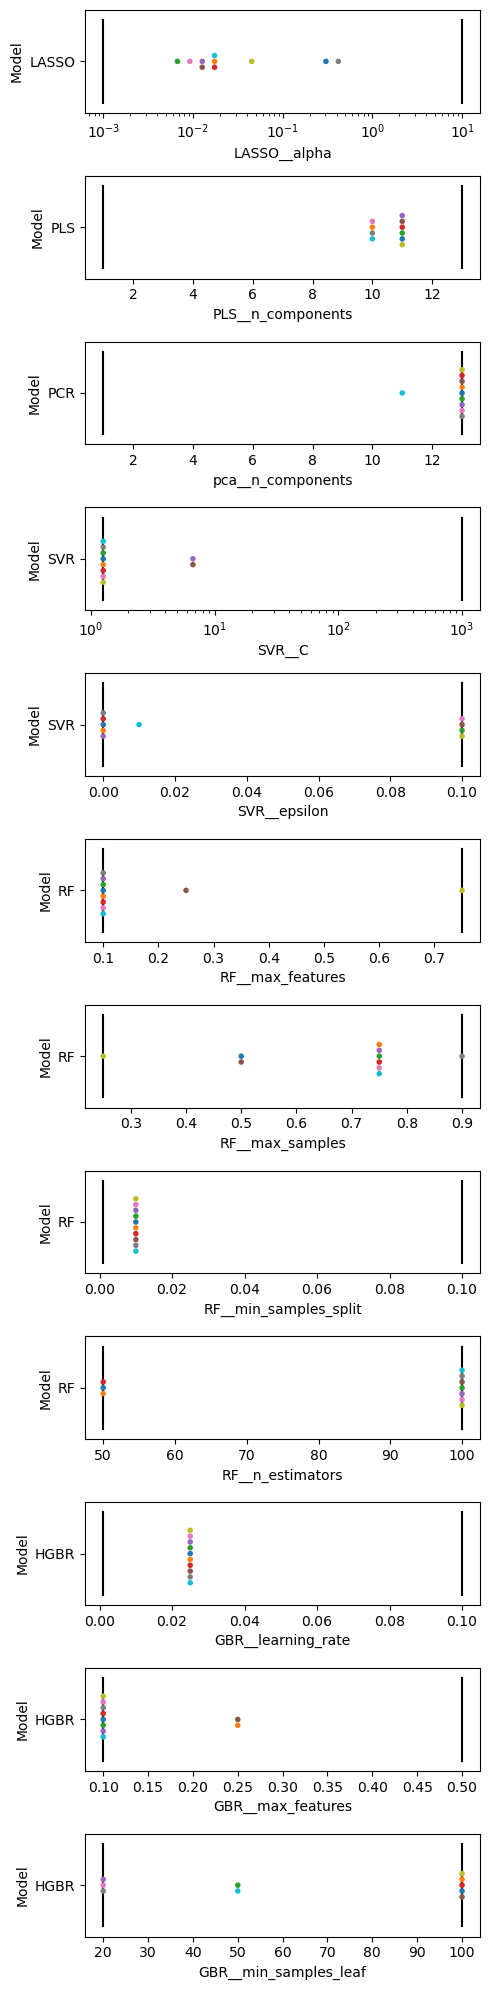

In [128]:
fig, axs = plt.subplots(nrows=len(param_dict.keys()), figsize=(5, 20))
for idx, k in enumerate(param_dict.keys()):
    ks = k.split('_')[0]
    if param_dict[k] in log_list:
        log_val = 10
    else:
        log_val = None
    sns.swarmplot(y='Model', x=param_dict[k], data=param_dfs[ks][param_dfs[ks]['Best'] == 1],
                  size=4,
                  hue='kfold',
                  orient='h',
                  legend=False,
                  ax=axs[idx],
                  log_scale=log_val
                 )
    axs[idx].axvline(x=param_dfs[ks][param_dict[k]].min(), ymin=0.1, ymax=0.9, color='black')
    axs[idx].axvline(x=param_dfs[ks][param_dict[k]].max(), ymin=0.1, ymax=0.9, color='black')
fig.tight_layout()

In [ ]:
sns.swarmplot(y='Model', x='LASSO__alpha', data=param_dfs['LASSO'][param_dfs['LASSO']['Best'] == 1],
              size=4,
              hue='kfold',
              orient='h',
              legend=False,
              ax=axs[0],
              log_scale=10
             )
axs[0].axvline(x=param_dfs['LASSO']['LASSO__alpha'].min(), ymin=0.1, ymax=0.9, color='black')
axs[0].axvline(x=param_dfs['LASSO']['LASSO__alpha'].max(), ymin=0.1, ymax=0.9, color='black')
#axs[0].set_xlim(-1, param_dfs['LASSO']['LASSO__alpha'].max()*1.2)


sns.swarmplot(y='Model', x='PLS__n_components', data=param_dfs['PLS'][param_dfs['PLS']['Best'] == 1],
              size=4,
              hue='kfold',
              orient='h',
              legend=False,
              ax=axs[1]
             )
axs[1].axvline(x=param_dfs['PLS']['PLS__n_components'].min(), ymin=0.1, ymax=0.9, color='black')
axs[1].axvline(x=param_dfs['PLS']['PLS__n_components'].max(), ymin=0.1, ymax=0.9, color='black')
#axs[0].set_xlim(-1, param_dfs['PLS']['PLS__n_components'].max()*1.2)

fig.tight_layout()

In [57]:
param_dfs['LASSO'][param_dfs['LASSO']['Best'] == 1]

Model kfold  Best       MAE LASSO__alpha
18   LASSO  2014     1 -4.142827      0.30392
39   LASSO  2015     1 -4.169643     0.017433
66   LASSO  2016     1 -4.239205     0.006723
99   LASSO  2017     1 -4.245733     0.017433
128  LASSO  2018     1 -4.278226      0.01269
158  LASSO  2019     1 -4.205008      0.01269
187  LASSO  2020     1 -4.408323     0.009237
229  LASSO  2021     1 -4.251044     0.417532
252  LASSO  2022     1 -4.218210     0.045204
279  LASSO  2023     1 -4.176098     0.017433

## Plot parameter tuning

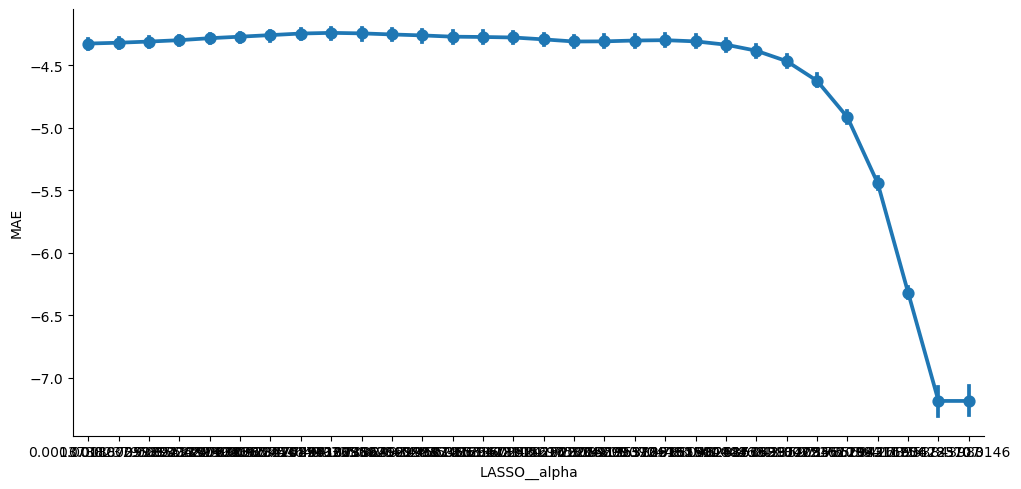

In [105]:
sns.catplot(x='LASSO__alpha', y='MAE', data=param_dfs['LASSO'], hue='kfold', kind='point', aspect=2)

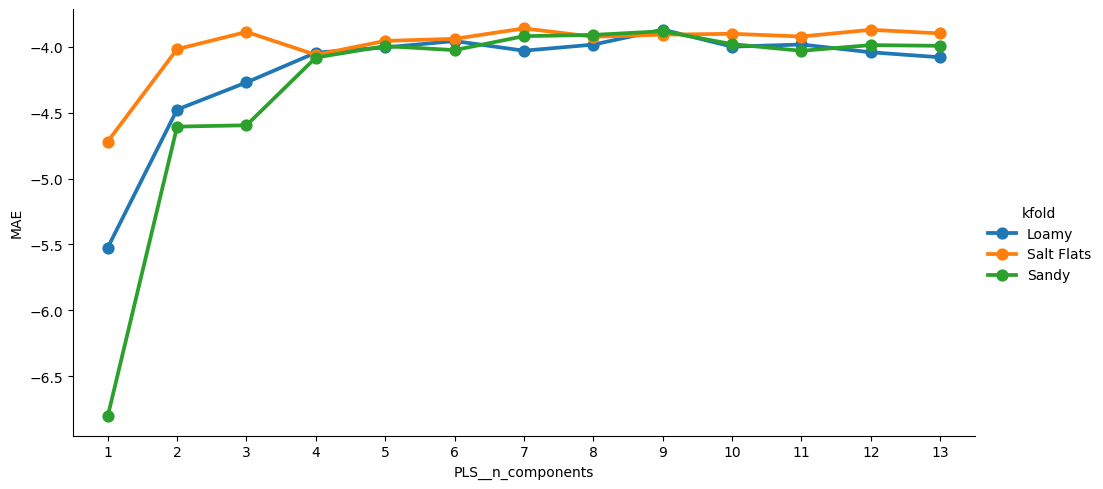

In [102]:
sns.catplot(x='PLS__n_components', y='MAE', data=param_dfs['PLS'], hue='kfold', kind='point', aspect=2)

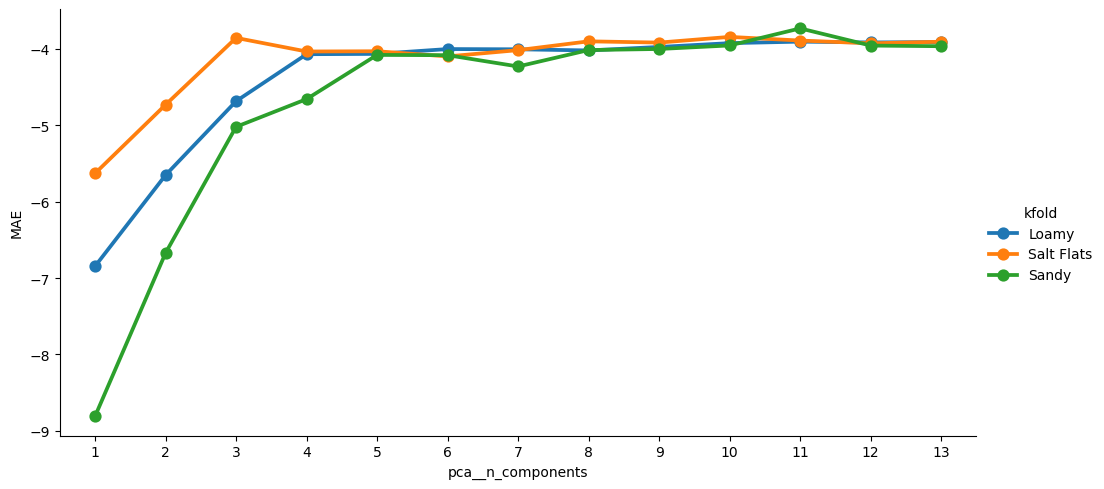

In [103]:
sns.catplot(x='pca__n_components', y='MAE', data=param_dfs['PCR'], hue='kfold', kind='point', aspect=2)

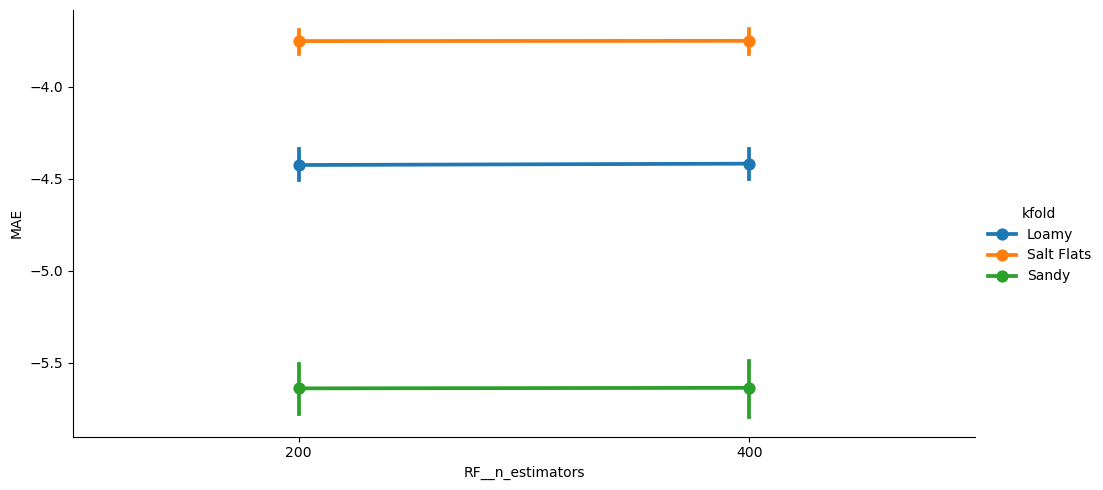

In [104]:
sns.catplot(x='RF__n_estimators', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

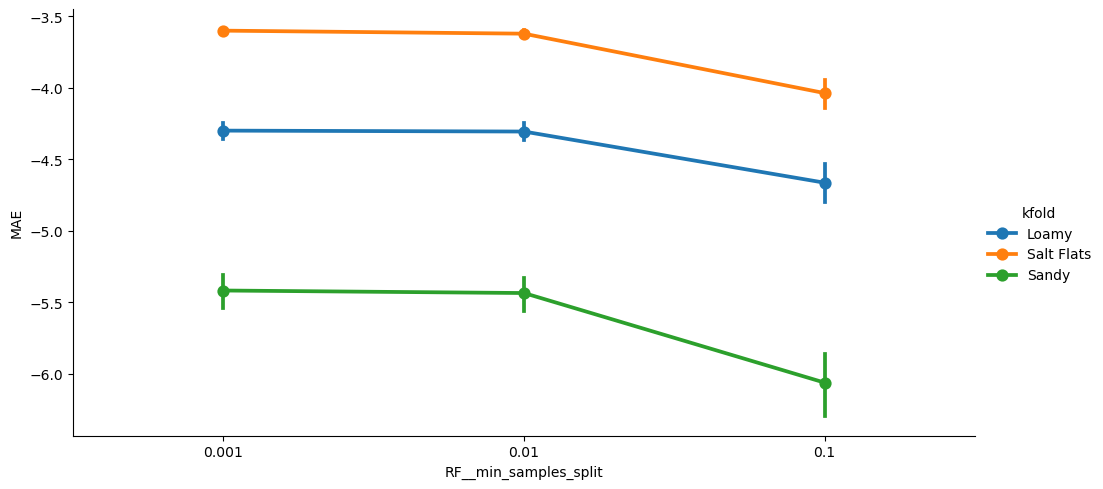

In [105]:
sns.catplot(x='RF__min_samples_split', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

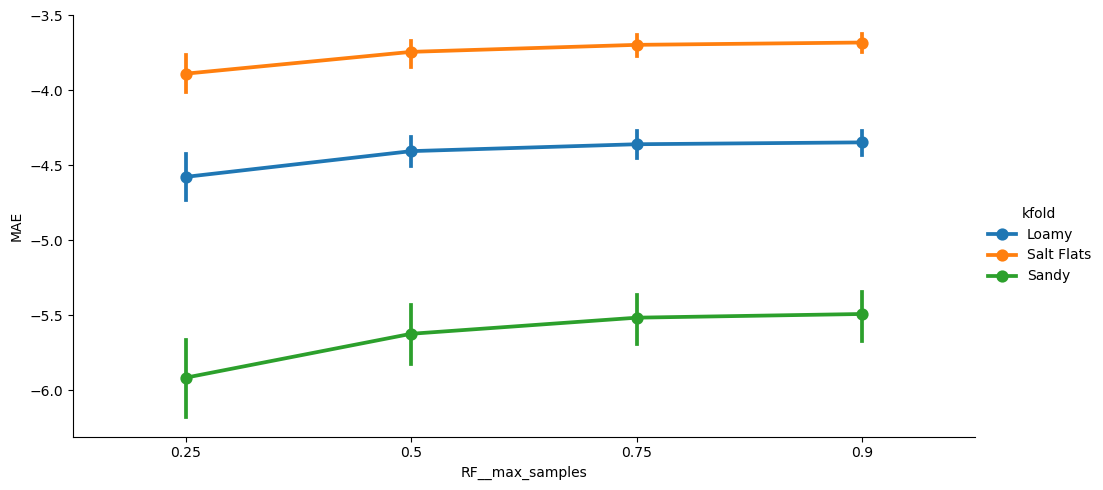

In [106]:
sns.catplot(x='RF__max_samples', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

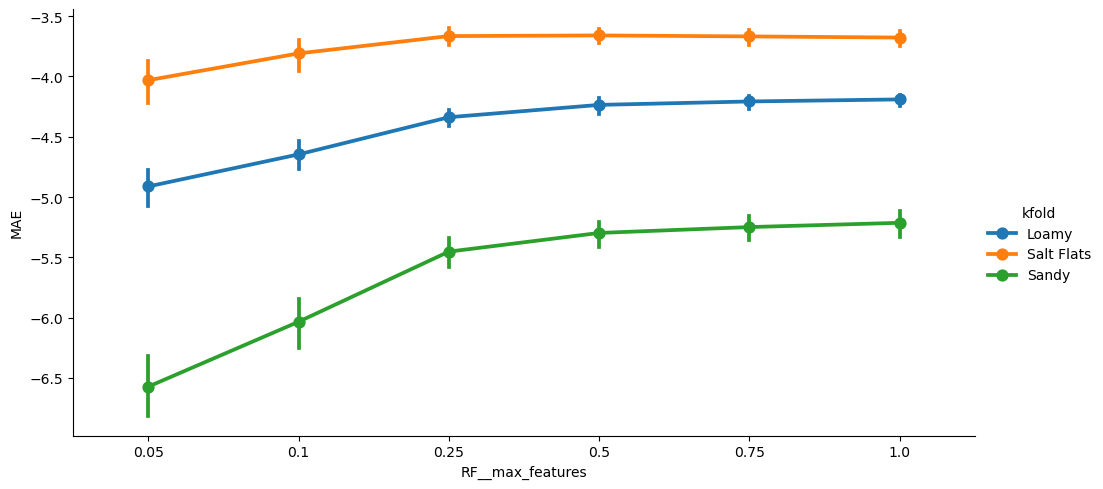

In [107]:
sns.catplot(x='RF__max_features', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

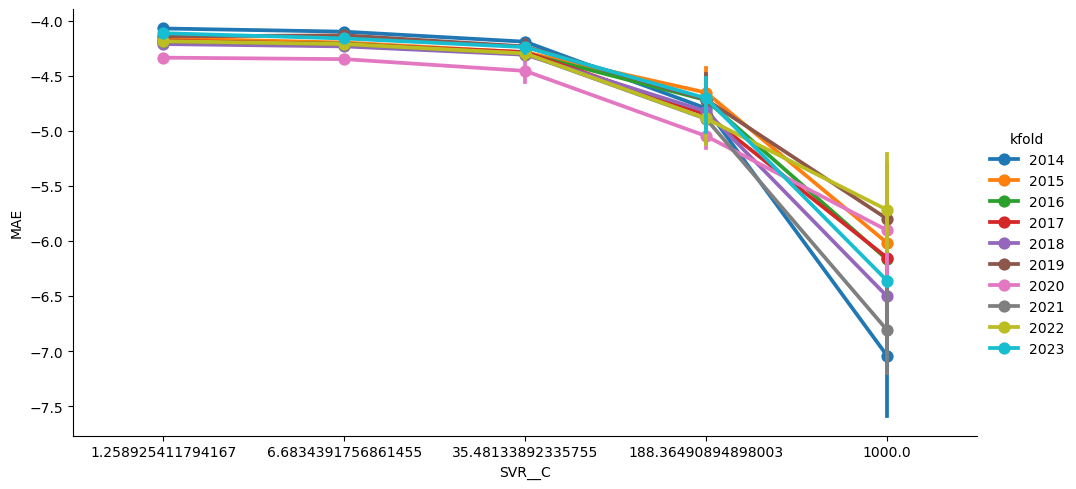

In [34]:
sns.catplot(x='SVR__C', y='MAE', data=param_dfs['SVR'], hue='kfold', kind='point', aspect=2)

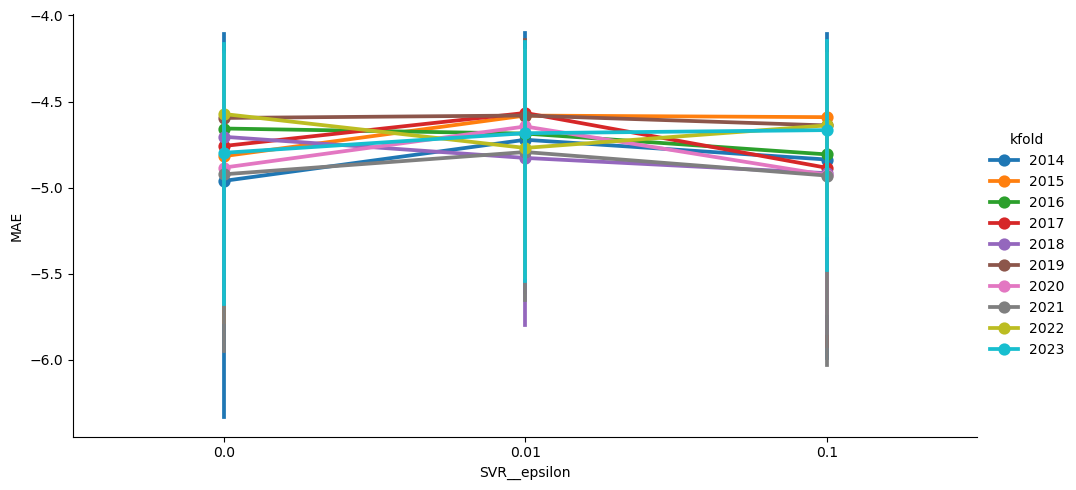

In [35]:
sns.catplot(x='SVR__epsilon', y='MAE', data=param_dfs['SVR'], hue='kfold', kind='point', aspect=2)

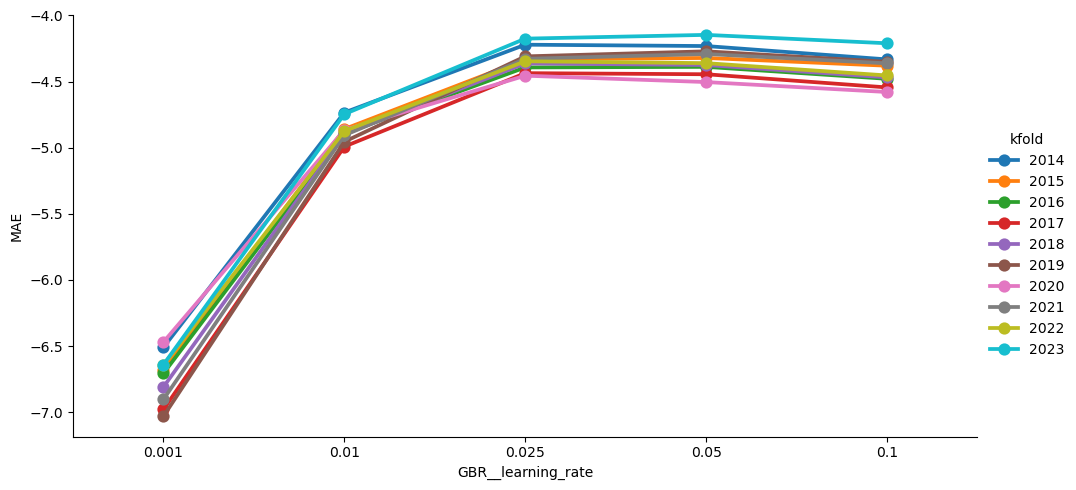

In [36]:
sns.catplot(x='GBR__learning_rate', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

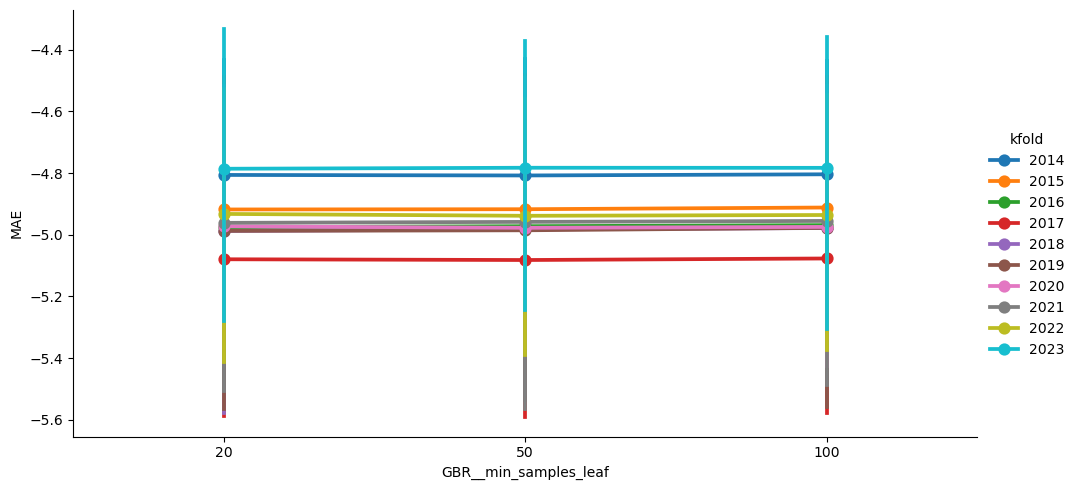

In [37]:
sns.catplot(x='GBR__min_samples_leaf', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

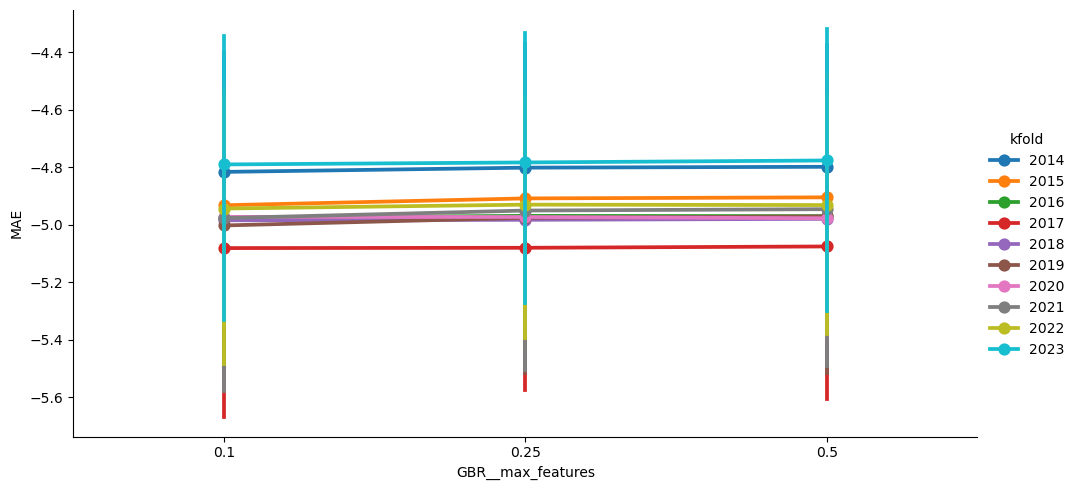

In [38]:
sns.catplot(x='GBR__max_features', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

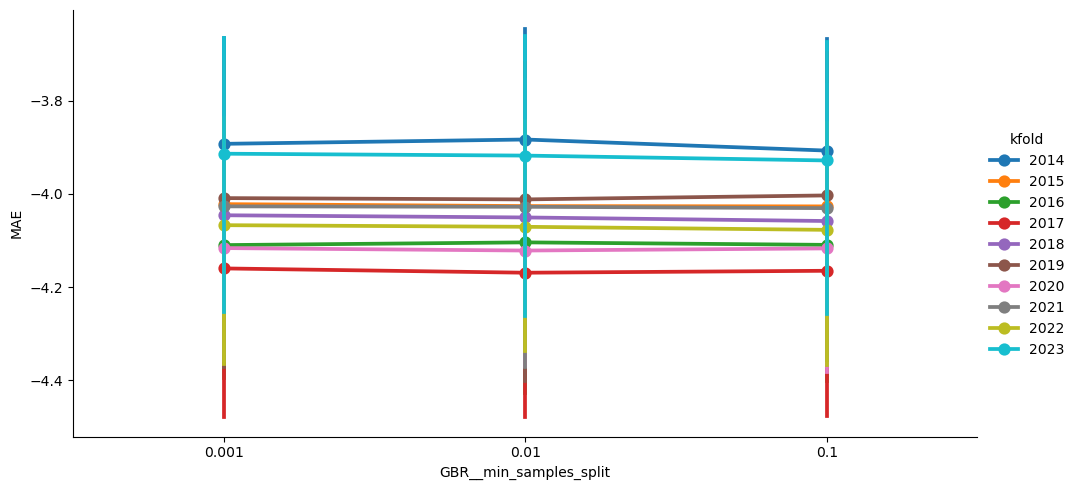

In [114]:
sns.catplot(x='GBR__min_samples_split', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

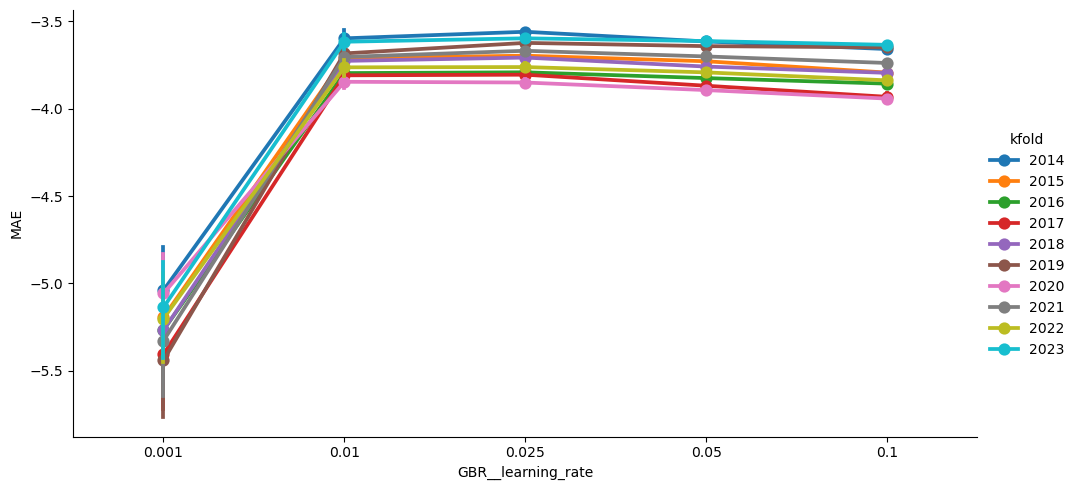

In [115]:
sns.catplot(x='GBR__learning_rate', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

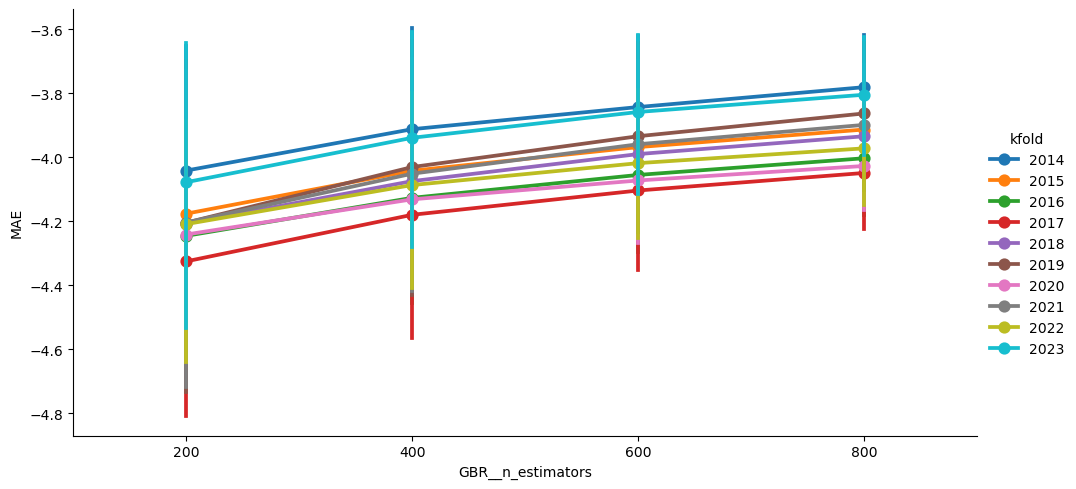

In [116]:
sns.catplot(x='GBR__n_estimators', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

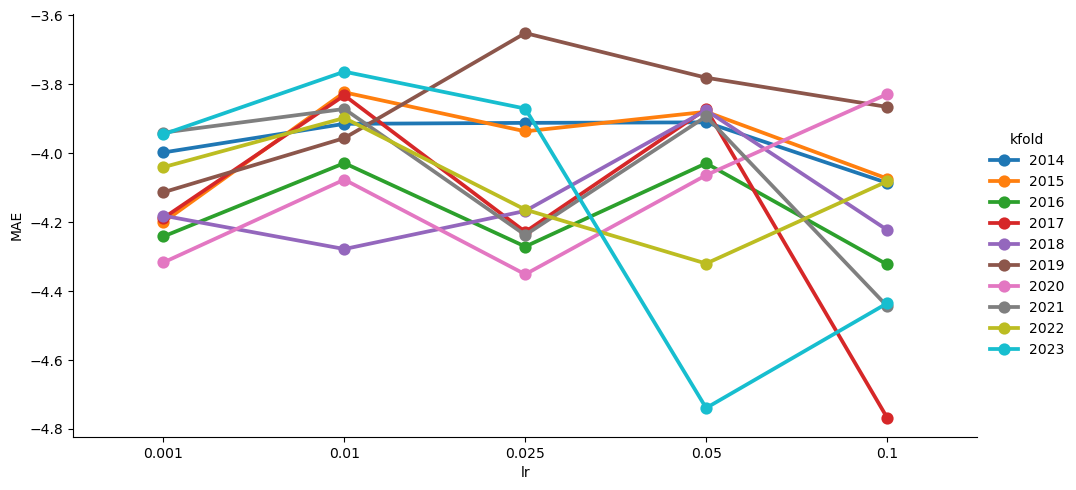

In [118]:
sns.catplot(x='lr', y='MAE', data=param_dfs['DNN'], hue='kfold', kind='point', aspect=2)